# Fase 3: Preparação de Dados e Busca (parte 1)

## 1. Introdução

Este relatório dá continuidade à etapa anterior de análise exploratória e compreensão da base de dados, avançando agora para a preparação dos dados e a realização de uma busca sistemática de hiperparâmetros em modelos de classificação supervisionados. Com base nas diretrizes metodológicas, o foco deste trabalho está em garantir rigor técnico e reprodutibilidade, além de maximizar o desempenho preditivo dos modelos avaliados.

Inicialmente, será apresentada uma visão geral da base de dados utilizada, retomando brevemente as principais características identificadas no relatório anterior. Em seguida, abordaremos com mais profundidade o processo de preparação dos dados, etapa fundamental para a construção de modelos consistentes. Nessa fase, serão aplicadas técnicas de normalização, além de estratégias para tratamento de valores ausentes e divisão estratificada dos dados em conjuntos de treino e teste.

A seguir, serão descritas as escolhas de modelos de classificação e os hiperparâmetros mais relevantes para cada um. Posteriormente, explicaremos o precoesso da metodologia aplicada para a busca dos hiper parâmetros.

Também será apresentado o monitoramento do desempenho durante a busca, seguido do treinamento final com os melhores parâmetros encontrados e da avaliação em conjunto de teste, utilizando métricas como acurácia, precisão, recall, F1-score e AUC-ROC. Uma análise comparativa entre os modelos será realizada, considerando aspectos como overfitting, estabilidade e desempenho geral.

Por fim, discutiremos os cuidados metodológicos aplicados ao longo de todas as etapas. Definimos como padrão uma seed para as funções e métodos que possuem uma abordagem heurística, colocando um Random State (Seed) de 51.


In [3]:
! pip install ucimlrepo -q

In [4]:
! pip install tqdm -q
! pip install scikit-learn -q
! pip install seaborn -q
! pip install matplotlib -q


In [5]:
from ucimlrepo import fetch_ucirepo
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings
import utils.plots as plots
from utils import filter_range
from utils.checkpoint import load_checkpoint, save_checkpoint
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)
import time
import random

RANDOM_STATE = 51
random.seed(RANDOM_STATE)

warnings.filterwarnings('ignore')

## 2. Base de Dados

A base de dados utilizada neste projeto é a **EEG Eye State**, previamente definida nas etapas iniciais e coletada diretamente do repositório público *UCI Machine Learning Repository*. Ela é composta por registros de sinais eletroencefalográficos (EEG) capturados por **14 eletrodos** posicionados na cabeça de um indivíduo, conforme o sistema internacional 10–20 de mapeamento. Cada linha da base representa um instante de tempo com os valores dos sinais elétricos em todos os canais e o respectivo **estado ocular (aberto = 0 ou fechado = 1)**.

#### Características Gerais

A base de dados EEG Eye State é composta por 14.980 instâncias, cada uma contendo 14 atributos contínuos que representam sinais elétricos captados por eletrodos posicionados na cabeça de um indivíduo, além de uma variável-alvo binária (`eyeDetection`) que indica se os olhos estão abertos ou fechados. Trata-se de um problema de classificação supervisionada binária com dados organizados em formato de série temporal. A ausência de valores nulos garante integridade ao conjunto, enquanto a distribuição das classes apresenta um leve desbalanceamento — cerca de 55% das amostras indicam olhos abertos e 45%, olhos fechados —, e alguns outliers muito discrepantes dos demais valores. Por fim, abaixo temos uma imagem da distribuição das classes, e da evolução temporal dos registros.

<p align="center">
  <img src="./images/distribuição.png" width="45%" style="display:inline-block; margin-right:10px;">
  <img src="./images/distribuição_perc.png" width="45%" style="display:inline-block;">
</p>

<p align="center">
  <img src="./images/evolução temporal 2.png" width="100%">
</p>

#### Relevância da Base

Essa base é amplamente utilizada em aplicações de **interface cérebro-computador**, com potencial de impacto em áreas como acessibilidade, jogos interativos, controle assistivo de dispositivos e diagnósticos em saúde. O reconhecimento automático do estado ocular, a partir de sinais cerebrais não invasivos, pode se tornar um componente essencial para sistemas de entrada alternativos — especialmente para pessoas com deficiência motora.

A estrutura do conjunto de dados e a boa qualidade dos registros possibilitaram análises detalhadas na fase anterior do projeto, como avaliação da **multicolinearidade entre canais**, **identificação e quantificação de outliers**, e **redução de dimensionalidade com PCA e t-SNE**. Tais análises forneceram as bases para as próximas etapas de preparação e modelagem, que serão conduzidas com atenção especial à preservação da integridade dos dados e à mitigação de ruídos e redundâncias.


## 3. Preparação dos dados

O carregamento da base foi feito por meio da biblioteca `ucirepo`, utilizando o identificador `id=264`, correspondente ao dataset EEG Eye State. Após o carregamento, os dados foram armazenados em dois objetos principais: `X`, contendo os atributos (sinais dos eletrodos), e `y`, contendo os rótulos (estado ocular).


In [6]:
eeg_eye_state = fetch_ucirepo(id=264)

X = eeg_eye_state.data.features
y = eeg_eye_state.data.targets

X, y = filter_range(3000, 6000, X, y)

📊 RESULTADO DA FILTRAGEM (Range: 3000 - 6000)
Dataset original: 14980 observações
Dataset filtrado: 14976 observações
Linhas removidas: 4 (0.03%)
Linhas mantidas: 99.97%



Em seguida, realizamos a divisão entre treino e teste com a função `train_test_split`, reservando 80% dos dados para o treinamento dos modelos e 20% para avaliação final. Importante destacar que utilizamos o parâmetro `stratify=y` para garantir que a proporção entre as classes fosse mantida em ambas as partições, o que é fundamental dado o leve desbalanceamento previamente identificado.

Durante o pré-processamento, inicialmente foram removidos **quatro registros** cujos valores estavam completamente fora do padrão observado. Essa decisão foi embasada por análises anteriores e reforçada por estudos semelhantes encontrados na literatura, que também desconsideraram essas amostras por representarem ruído extremo.

Após a filtragem, aplicamos normalização com o `StandardScaler`, uma vez que as distribuições dos atributos numéricos mostraram-se próximas da normal. A normalização foi ajustada exclusivamente com base no conjunto de treino, e os mesmos parâmetros foram aplicados posteriormente ao conjunto de teste, de modo a evitar data leakage.

Não foi necessário aplicar técnicas de encoding, uma vez que não há variáveis categóricas na base, nem realizar tratamentos para valores ausentes, já que o dataset é completo e consistente.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 4. Seleção de Modelos

Para este etapa, selecionamos cinco algoritmos de classificação supervisionada com abordagens distintas e complementares: Árvore de Decisão (Decision Tree), K Vizinhos Mais Próximos (KNN), Máquinas de Vetores de Suporte (SVM), Floresta Aleatória (Random Forest) e Learning Vector Quantization (LVQ). Essa diversidade permite avaliar diferentes formas de aprendizado e generalização dos dados, otimizando as chances de encontrar um modelo de alto desempenho.

### 4.1 Decision Tree (Árvore de Decisão)

A Árvore de Decisão é um modelo baseado em regras hierárquicas que divide o espaço de atributos em regiões homogêneas por meio de perguntas binárias. É de fácil interpretação, sensível ao overfitting e bastante eficaz em bases com padrões bem definidos.

Hiperparâmetros selecionados:

- **max_depth**: este parâmetro controla a profundidade máxima da árvore. Uma profundidade maior permite que o modelo aprenda padrões mais complexos, mas aumenta o risco de overfitting. Variamos com os valores [3, 5, 10, 20, 40, 60, 100, None] para testar desde árvores mais rasas (mais generalistas) até árvores muito profundas (mais específicas).

- **min_samples_split**: define o número mínimo de amostras necessário para que um nó seja dividido. Valores maiores tendem a gerar árvores mais simples e generalistas. Utilizamos [2, 5, 10, 20, 30] para verificar como o aumento no critério de divisão impacta a complexidade do modelo.

- **min_samples_leaf**: especifica o número mínimo de amostras exigidas em uma folha. Isso ajuda a evitar folhas com poucas amostras, que podem ser muito específicas ao treino. Variamos entre [1, 2, 4, 5, 10] para testar o equilíbrio entre detalhamento e generalização.

- **criterion**: determina a função usada para medir a qualidade das divisões. Utilizamos os critérios gini (impureza de Gini) e entropy (entropia de informação) para comparar qual função melhor separa as classes nesse problema específico.

In [8]:
from sklearn.tree import DecisionTreeClassifier

params_dt = {
    'max_depth': [3, 5, 10, 20, 40, 60, 100, None],
    'min_samples_split': [2, 5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4, 5, 10],
    'criterion': ['gini', 'entropy']
}

### 4.2 K-Nearest Neighbors (KNN)

O K-Nearest Neighbors é um classificador baseado em instâncias, que prediz o rótulo de uma nova amostra com base nos rótulos das amostras mais próximas no espaço de atributos. É um modelo simples, não paramétrico e muito eficaz quando os dados apresentam uma estrutura espacial coerente.

Hiperparâmetros selecionados:

- **n_neighbors**: define o número de vizinhos considerados na votação. Valores pequenos tornam o modelo mais sensível a ruídos, enquanto valores maiores promovem maior suavização. Variamos com [1, 2, 3, 5, 7, 10, 30, 50, 100] para avaliar o impacto de k pequenos até valores maiores e mais generalistas.

- **weights**: determina se todos os vizinhos têm a mesma influência (uniform) ou se os mais próximos devem ter maior peso (distance). Essa escolha permite testar se a distância deve influenciar diretamente na predição.

- **algorithm**: especifica o algoritmo usado para encontrar os vizinhos mais próximos. Usamos ['auto', 'ball_tree', 'kd_tree', 'brute'] para permitir ao scikit-learn escolher o melhor método automaticamente ou testar diferentes abordagens de busca.

- **leaf_size**: parâmetro relevante para algoritmos baseados em árvore (kd_tree, ball_tree), influencia a velocidade de construção da árvore e tempo de consulta. Variamos entre [5, 10, 20, 30, 40, 50, 60, 100] para explorar o desempenho computacional em diferentes estruturas.

- **p**: define a potência da métrica de distância de Minkowski. Com p=1, a distância é Manhattan; com p=2, é Euclidiana. Testamos valores de [1, 2, 3, 4] para avaliar qual métrica se adapta melhor à geometria dos dados.

In [9]:
from sklearn.neighbors import KNeighborsClassifier

params_knn = {
    'n_neighbors': [1, 2, 3, 5, 7, 10, 30, 50, 100],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [5, 10, 20, 30, 40, 50, 60, 100],
    'p': [1, 2, 3, 4],
}

### 4.3 Support Vector Machine (SVM)

A Support Vector Machine (SVM) é um modelo que busca encontrar o hiperplano ótimo que melhor separa as classes no espaço de atributos, maximizando a margem entre elas. É eficaz em problemas com fronteiras complexas e se destaca por sua robustez mesmo em espaços de alta dimensão.

Hiperparâmetros selecionados:

- **C**: parâmetro de regularização que controla o trade-off entre maximizar a margem e minimizar o erro de classificação. Valores menores (0.01, 0.1) promovem uma margem mais ampla com maior tolerância a erros; valores maiores (10, 100, 1000) tentam separar as classes com mais precisão. Testamos uma ampla faixa para equilibrar generalização e performance.

- **kernel**: define a função de transformação usada para projetar os dados em um espaço de maior dimensão. Variamos entre ['linear', 'poly', 'rbf', 'sigmoid'] para comparar diferentes formas de separação, incluindo fronteiras lineares e não lineares.

- **gamma**: controla a influência de cada ponto de treinamento nas fronteiras. Valores baixos (0.001, 0.01) resultam em decisões mais suaves; valores altos (1) tornam o modelo mais sensível aos pontos individuais. Também testamos ['scale', 'auto'], que ajustam gamma automaticamente com base nas variâncias dos dados.

- **shrinking**: ativa ou desativa uma heurística de otimização que pode acelerar o processo de treinamento. Testamos True e False para verificar seu impacto no tempo e desempenho.

- **tol**: define a tolerância para os critérios de parada. Menores tolerâncias (1e-4) indicam maior precisão nas iterações, enquanto tolerâncias maiores (1e-2) aceleram o processo com menor rigor.

- **max_iter**: especifica o número máximo de iterações do otimizador. Testamos [100, 1000, 5000] para observar o comportamento da convergência sob diferentes restrições computacionais.

In [10]:
from sklearn.svm import SVC

params_svm = {
    'C': [0.01, 0.1, 1, 10, 100, 1000], 
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1], 
    'shrinking': [True, False], 
    'tol': [1e-4, 1e-3, 1e-2],
    'max_iter': [100, 1000, 5000],
}


### 4.4 Random Forest

Random Forest é um algoritmo de ensemble baseado em múltiplas Árvores de Decisão. Cada árvore é treinada em subconjuntos diferentes dos dados e dos atributos, promovendo diversidade entre os modelos e, consequentemente, maior robustez e resistência ao overfitting.

Hiperparâmetros selecionados:

- **n_estimators**: número de árvores na floresta. Mais árvores geralmente melhoram a estabilidade e a precisão, mas aumentam o custo computacional. Testamos [50, 100, 150, 200, 250, 500] para encontrar um bom equilíbrio.

- **max_depth**: limita a profundidade de cada árvore, prevenindo overfitting. Valores como 10, 20, 30 oferecem modelos mais rasos e generalistas, enquanto None permite que a árvore cresça totalmente.

- **min_samples_split**: número mínimo de amostras necessárias para dividir um nó interno. Usamos [2, 5, 10, 20] para ajustar a granularidade das divisões.

- **min_samples_leaf**: número mínimo de amostras exigidas em cada folha. Testamos [1, 2, 4, 10] para evitar folhas com amostras isoladas, que podem causar overfitting.

- **max_features**: número máximo de atributos considerados em cada divisão. Usamos 'auto', 'sqrt', 'log2' e None para comparar estratégias de redução de variância e diversidade entre as árvores.

- **class_weight**: define pesos para as classes durante o aprendizado. None ignora o desbalanceamento; 'balanced' e 'balanced_subsample' ajustam os pesos com base na frequência das classes, uma medida importante dada a leve assimetria do dataset.

In [11]:
from sklearn.ensemble import RandomForestClassifier

params_rf = {
    'n_estimators': [50, 100, 150, 200, 250, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20], 
    'min_samples_leaf': [1, 2, 4, 10],  
    'max_features': ['auto', 'sqrt', 'log2', None],  
    'class_weight': [None, 'balanced', 'balanced_subsample'], 
}


### 4.5 Learning Vector Quantization (LVQ)

O Learning Vector Quantization (LVQ) é um algoritmo inspirado em redes neurais competitivas. Ele utiliza vetores representativos chamados codebooks para mapear a distribuição das classes no espaço de atributos. Durante o treinamento, esses vetores são ajustados conforme a distância das amostras, aproximando-se dos pontos corretos e afastando-se dos incorretos.

Por não ser uma implementação nativa do scikit-learn, os hiperparâmetros disponíveis são definidos diretamente no construtor da classe. A seguir estão os principais parâmetros que impactam o desempenho do LVQ:

Hiperparâmetros selecionados:

- **n_codebooks**: número total de vetores protótipos (codebooks) utilizados. Esse valor afeta diretamente a capacidade de representação do modelo. Testamos [2, 3, 4, 5], considerando que mais codebooks permitem maior detalhamento da distribuição, mas aumentam o risco de overfitting.

- **lrate** (learning rate): taxa de aprendizado. Taxas mais altas (como 0.2, 0.5) fazem ajustes mais agressivos nos vetores, enquanto taxas mais baixas (0.01) são mais conservadoras. Avaliamos [0.01, 0.03, 0.05, 0.08, 0.1].

- **epochs**: número de passagens completas sobre o dataset. Mais épocas permitem que os protótipos se ajustem com maior precisão. Foram testados [20, 50, 100].

In [ ]:
parameter_sets = [
    {'n_codebooks': 2, 'lrate': 0.1, 'epochs': 20},
    {'n_codebooks': 3, 'lrate': 0.05, 'epochs': 50},
    {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 100},
    {'n_codebooks': 4, 'lrate': 0.08, 'epochs': 50},
    {'n_codebooks': 2, 'lrate': 0.03, 'epochs': 20},
]

## 5. Metodologia

Esta seção descreve a metodologia aplicada para a escolha dos melhores hiperparâmetros e avaliação final dos modelos treinados. Todo o processo foi construído com foco na reprodutibilidade, prevenção de vazamentos de dados (data leakage), e validação criteriosa da estabilidade dos modelos.

### 5.1 Critério de Escolha

Com base na revisão da literatura realizada na primeira etapa do projeto, optamos por utilizar acurácia como métrica principal para a seleção dos modelos. Observamos que diversos estudos anteriores adotam a acurácia como referência primária de desempenho para o dataset EEG Eye State, o que reforça sua adequação para o problema em questão.

### 5.2 Busca de Hiperparâmetros

Para a busca de hiperparâmetros, utilizamos o RandomizedSearchCV, do scikit-learn, com 20 iterações para cada modelo. A validação cruzada foi feita utilizando o StratifiedKFold com 5 divisões (k=5), com estratificação das classes para manter o equilíbrio entre olhos abertos e fechados em cada partição.

A cada nova execução do RandomizedSearchCV, incrementamos o valor do random_state, garantindo que diferentes combinações de parâmetros fossem testadas. Os melhores parâmetros de cada rodada foram armazenados e posteriormente analisados por meio de um gráfico de frequência, o qual permite identificar quais combinações ou valores de parâmetros se destacaram repetidamente ao longo das buscas.

In [19]:
def search_hyperparameters(estimator, params, estm_name, metric='accuracy', n_iter=20, qnt_params=20):
    checkpoint = load_checkpoint(estm_name)
    
    best_params = checkpoint.get('best_params', [])
    total_time = checkpoint.get('total_time', 0)
    
    for i in tqdm(range(len(best_params),qnt_params), desc="Searching Hyperparameters"):
        start_time = time.time()
        
        randomized_search = RandomizedSearchCV(
            estimator,
            param_distributions=params,
            n_iter=n_iter,
            scoring=metric,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE + i),
            random_state=RANDOM_STATE + i,
            n_jobs=-1,
            verbose=3
        )
        randomized_search.fit(X_train, y_train)
        
        total_time += time.time() - start_time
        best_params.append(randomized_search.best_params_)
        save_checkpoint(estm_name, {'best_params': best_params, 'total_time': total_time})
    
    plots.plot_param_frequencies(best_params)
    print(f"Time taken for hyperparameter search: {total_time:.2f} seconds")
    return best_params

### 5.3 Análise de Estabilidade

Após obter os 20 melhores conjuntos de parâmetros para cada modelo, realizamos uma nova validação cruzada para avaliar estabilidade e robustez de cada configuração. Para isso, medimos a média e o desvio padrão da acurácia em cada um dos k-folds.

A ideia central é selecionar o modelo com maior média de desempenho entre os 25% mais estáveis (ou seja, com menor desvio padrão). Essa estratégia ajuda a evitar escolhas baseadas apenas em um bom desempenho pontual, priorizando combinações de hiperparâmetros que performam bem de forma consistente.

Durante esse processo, também plotamos a relação entre estabilidade (desvio padrão) e desempenho (média da acurácia), destacando visualmente os modelos mais promissores. Em seguida, para o modelo selecionado, plotamos a acurácia obtida em cada fold individualmente, com o objetivo de identificar flutuações ou anomalias de desempenho.

In [14]:

def cross_val_stability_analysis(estimator_class, param_list, metric='accuracy'):
    means = []
    stds = []
    all_scores = []
    for params in tqdm(param_list, desc="Cross-Validation for Params"):
        model = estimator_class(**params)
        scores = cross_val_score(model, X_train, y_train.values.ravel(), cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), scoring=metric)
        means.append(np.mean(scores))
        stds.append(np.std(scores))
        all_scores.append(scores)

    # Separar modelos mais estáveis (menor desvio padrão)
    stability_threshold = np.percentile(stds, 25)
    stable_idxs = [i for i, s in enumerate(stds) if s <= stability_threshold]
    unstable_idxs = [i for i, s in enumerate(stds) if s > stability_threshold]

    # Plot separando estáveis e instáveis
    plots.plot_stability_vs_metric(stds, means, stable_idxs, unstable_idxs, metric)

    # Selecionar o modelo mais estável com maior média da métrica
    best_idx = max(stable_idxs, key=lambda i: means[i]) if stable_idxs else np.argmax(means)
    best_params = param_list[best_idx]
    best_scores = all_scores[best_idx]

    # Plot da métrica em cada fold para o melhor modelo
    plots.plot_metric_per_fold(best_scores, metric)

    return best_params


### 5.4 Avaliação Final dos Modelos

Com o modelo mais estável e com melhor desempenho médio escolhido, passamos para a fase final de avaliação. Essa etapa envolve tanto o conjunto de treinamento quanto o conjunto de teste, e tem como objetivo verificar a capacidade de generalização do modelo e identificar sinais de overfitting.

A primeira análise consiste em um treinamento progressivo: iniciamos com 20% do conjunto de treino e aumentamos o tamanho gradualmente em incrementos de 5%, até alcançar os 100%. Em cada etapa, medimos a métrica escolhida (acurácia, F1, precisão ou recall) tanto no treino quanto no teste. Essa análise permite visualizar se o modelo continua melhorando no teste à medida que recebe mais dados ou se passa a superajustar (overfitting) ao conjunto de treino.

Em seguida, treinamos o modelo completo com os melhores parâmetros e realizamos:
- Matriz de confusão para visualizar os erros de classificação por classe;
- Curva ROC e cálculo da AUC para medir a capacidade discriminativa do modelo;
- Cálculo das principais métricas (acurácia, F1-score, precisão e recall) separadamente para treino e teste.

As métricas e visualizações obtidas nessa etapa final são utilizadas para comparação entre os diferentes modelos testados (Decision Tree, KNN, SVM, Random Forest, LVQ), permitindo avaliar não apenas qual modelo teve a melhor performance bruta, mas também qual apresentou maior equilíbrio entre desempenho e robustez.

In [15]:
def evaluate_and_plot(params, model_class, metric='accuracy', model_name=None):
    
    model = model_class(**params, random_state=RANDOM_STATE) if 'random_state' in model_class().get_params() else model_class(**params)
    train_scores, test_scores = [], []
    percents = np.arange(0.2, 1.01, 0.05)
    scorer = {
        'accuracy': accuracy_score,
        'f1': f1_score,
        'precision': precision_score,
        'recall': recall_score
    }[metric]
    for p in percents:
        n = int(p * len(X_train))
        model.fit(X_train[:n], y_train[:n])
        y_pred_train = model.predict(X_train[:n])
        y_pred_test = model.predict(X_test)
        train_scores.append(scorer(y_train[:n], y_pred_train))
        test_scores.append(scorer(y_test, y_pred_test))
        
    
    plots.plot_metric_evolution(percents, train_scores, test_scores, metric)

    # Treinamento completo
    model = model_class(**params, random_state=RANDOM_STATE) if 'random_state' in model_class().get_params() else model_class(**params)
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    plots.plot_confusion_matrix(y_test, y_pred_test, model_class.__name__)

    auc_score = plots.plot_roc_curve(model, X_test, y_test, model_class.__name__)

    metrics_dict = {
        "accuracy_train": accuracy_score(y_train, y_pred_train),
        "accuracy_test": accuracy_score(y_test, y_pred_test),
        "f1_train": f1_score(y_train, y_pred_train),
        "f1_test": f1_score(y_test, y_pred_test),
        "precision_train": precision_score(y_train, y_pred_train),
        "precision_test": precision_score(y_test, y_pred_test),
        "recall_train": recall_score(y_train, y_pred_train),
        "recall_test": recall_score(y_test, y_pred_test),
        "auc": auc_score
    }
    
    if model_name is None:
        model_name = model_class.__name__
    
    plots.plot_main_metrics(metrics_dict, model_name)

    return metrics_dict

### 5.5 Cuidados Metodológicos

Durante toda a execução da metodologia, foram adotados cuidados fundamentais para garantir validade e reprodutibilidade dos resultados:

- **Prevenção de data leakage**: todos os pré-processamentos foram ajustados exclusivamente no conjunto de treino e aplicados posteriormente no teste.

- **Validação estratificada**: todas as validações cruzadas respeitaram a distribuição original das classes.

- **Reprodutibilidade**: o parâmetro random_state foi definido e documentado em todas as etapas que envolvem aleatoriedade.

- **Eficiência computacional**: utilizamos n_jobs = -1 para paralelização da busca, além de RandomizedSearchCV em vez de GridSearchCV, visando economia de tempo em espaços de busca extensos.

- **Interpretação criteriosa**: múltiplas métricas foram analisadas e cruzadas entre treino e teste para identificar possíveis problemas de variância, viés ou generalização.

## 6. Busca e Avaliação de Hiper Parâmetros

### 6.1 Decision Tree (Árvore de Decisão)

A busca pelos 20 melhores conjuntos de hiperparâmetros para o modelo de Árvore de Decisão foi a mais rápida entre todos os modelos testados, com tempo total de 25.22 segundos. Isso demonstra a leveza computacional desse algoritmo.

Em relação aos hiperparâmetros otimizados:

- **min_samples_split**: A maior frequência se concentrou nos valores 2 e 5, com leve predominância do 2. Isso indica uma tendência do modelo em preferir divisões mais agressivas, o que está associado a árvores mais profundas.

- **min_samples_leaf**: Os valores mais frequentes foram 1 e 2, novamente refletindo uma tendência para folhas pequenas, o que potencializa o overfitting, mas pode ser desejável em problemas com padrões bem definidos.

- **max_depth**: O valor 20 foi o mais escolhido, enquanto valores como 40, 60 e 100 também apareceram com menor frequência. A presença do valor None (sem restrição) foi rara ou ausente.

- **criterion**: O critério entropy teve ampla predominância sobre o gini, sugerindo que o modelo se beneficiou da divisão baseada em ganho de informação.

Abaixo, a distribuição dos hiperparâmetros mais frequentes:

Searching Hyperparameters:   0%|          | 0/20 [00:00<?, ?it/s]

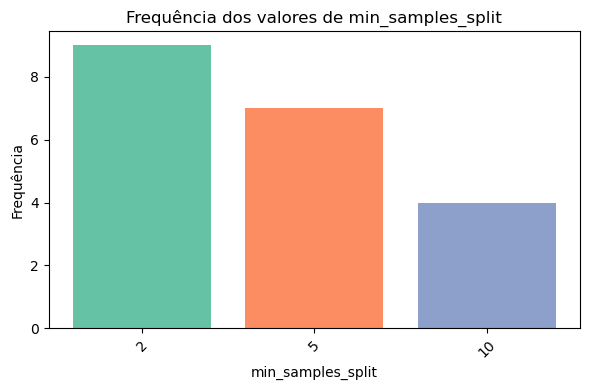

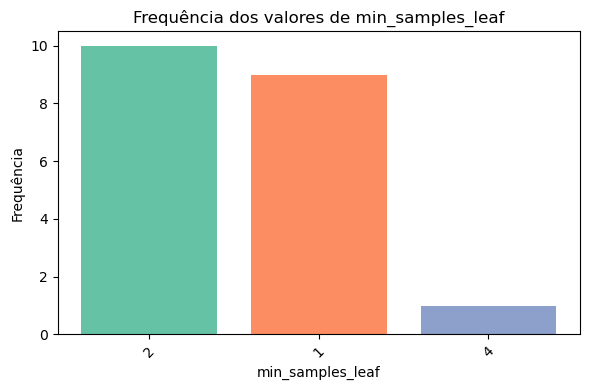

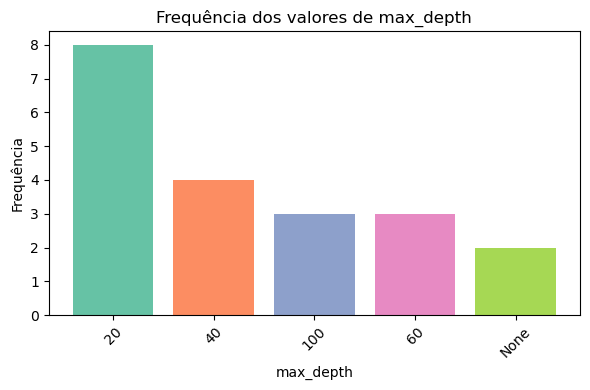

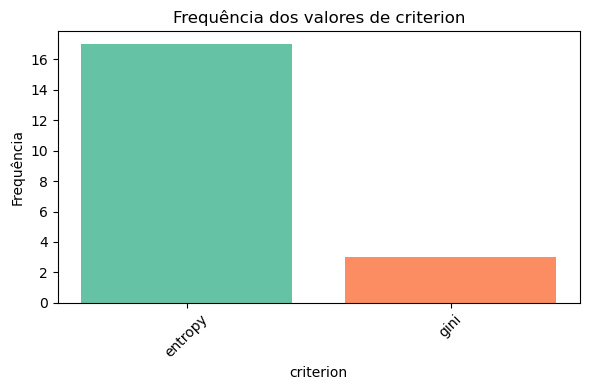

Time taken for hyperparameter search: 25.22 seconds


In [ ]:
best_params_dt = search_hyperparameters(DecisionTreeClassifier(), params_dt,'dt' ,metric='accuracy')

Durante a análise de estabilidade via validação cruzada dos 20 melhores conjuntos, apenas 4 foram considerados estáveis, ou seja, apresentaram baixa variação entre as métricas nas diferentes dobras. Isso indica que o modelo de árvore de decisão, embora rápido, apresenta alta sensibilidade às divisões dos dados — um sinal comum de overfitting. O modelo selecionado para a etapa final não foi o de melhor média geral, mas sim o segundo melhor, pois este foi o mais estável entre os que apresentaram desempenho competitivo. Essa escolha equilibrada priorizou robustez em relação à generalização, em vez de apenas acurácia máxima. Abaixo temos um gráfico que mostra a estabilidade de cada modelo e a acurácia do modelo escolhido ao logo de cada k-fold.

Cross-Validation for Params:   0%|          | 0/20 [00:00<?, ?it/s]

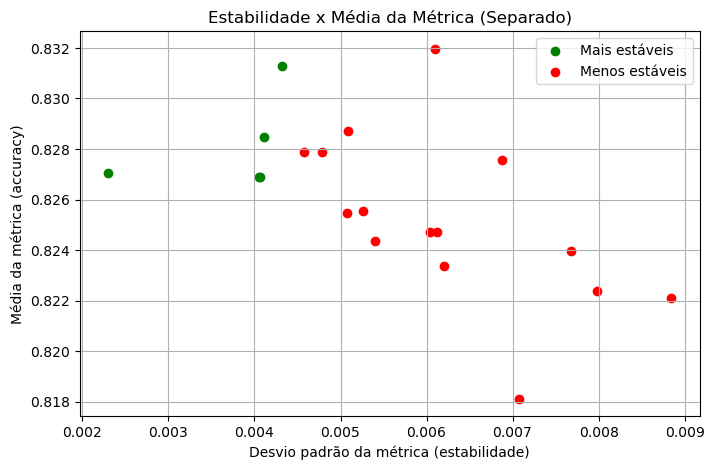

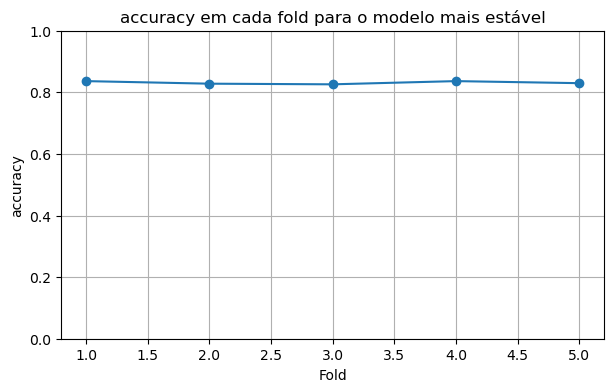

In [14]:
best_param_dt = cross_val_stability_analysis(DecisionTreeClassifier, best_params_dt, metric='accuracy')

A seguir, as métricas obtidas pelo melhor modelo selecionado:

| Métrica            | Treino | Teste |
| ------------------ | ------ | ----- |
| Acurácia           | 1.00   | 0.842 |
| F1-score           | 1.00   | 0.825 |
| Precisão           | 1.00   | 0.821 |
| Revocação (Recall) | 1.00   | 0.829 |
| AUC                | —      | 0.841 |

O modelo claramente sofreu de **overfitting severo**, com performance perfeita no treino, mas consideravelmente inferior no teste. Ainda assim, apresentou desempenho acima de 82% em todas as métricas principais de teste, o que demonstra certo potencial.

A curva de aprendizado abaixo mostra como a **acurácia de teste melhora conforme mais dados são utilizados**, enquanto a de treino permanece em 1.0 — evidência clara de que o modelo decorou o conjunto de treinamento:

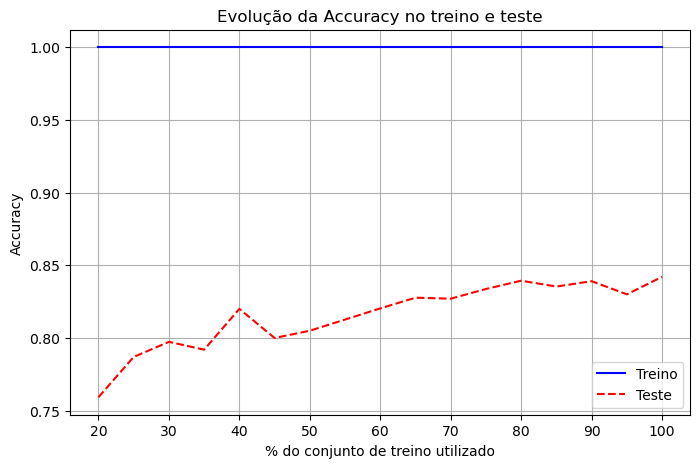

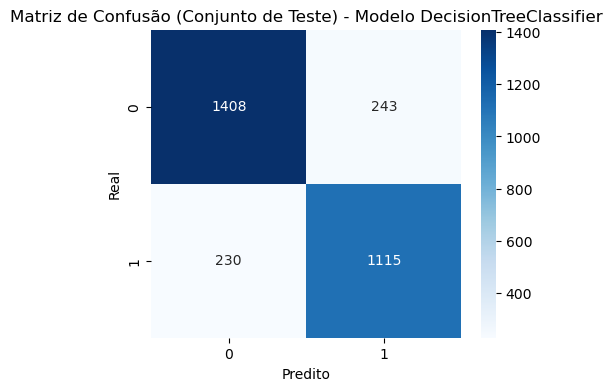

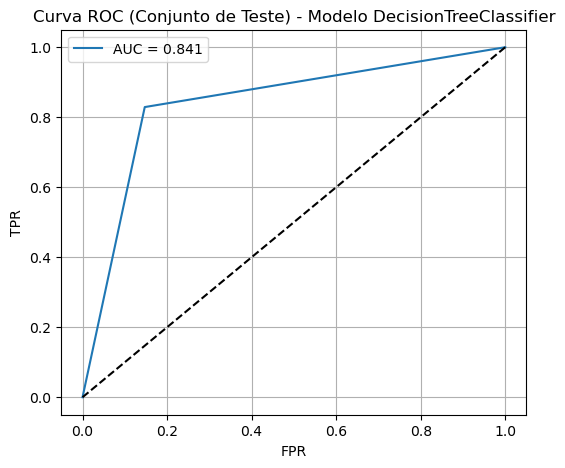

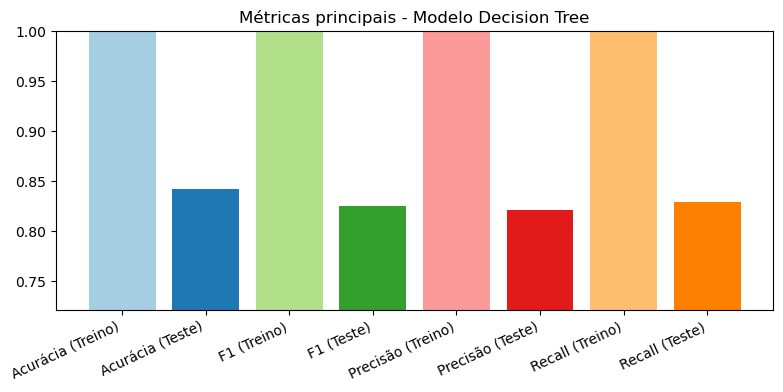

In [15]:
results_dt = evaluate_and_plot(best_param_dt, DecisionTreeClassifier, metric='accuracy', model_name='Decision Tree')

### 6.2 K-Nearest Neighbors (KNN)

A busca pelos melhores hiperparâmetros do modelo KNN levou um tempo total de 51.38 segundos, sendo ligeiramente superior ao tempo da Árvore de Decisão. O KNN apresenta uma variedade maior de combinações possíveis, principalmente devido à sensibilidade dos parâmetros p e n_neighbors.

Nos 20 melhores resultados obtidos, 17 configurações distintas foram encontradas. Abaixo destacam-se os comportamentos observados:

- **weights**: O valor distance apareceu com muita frequência, sendo escolhido em 15 das 20 execuções. Isso sugere que dar maior peso aos vizinhos mais próximos melhora a performance do modelo neste caso.

- **p** (métrica de distância): Os valores mais frequentes foram 1, 2 e 3, com destaque para p=2 (distância euclidiana) e p=1 (manhattan), demonstrando que diferentes métricas são viáveis, embora p=2 ainda seja padrão.

- **n_neighbors**: O modelo mostrou forte preferência por valores baixos, especialmente n_neighbors=1, que apareceu em 12 dos 20 modelos, indicando um comportamento de alta sensibilidade local.

- **leaf_size**: Embora varie amplamente (de 5 a 100), a faixa entre 30 e 60 apareceu com maior frequência. Este parâmetro afeta a performance, mas não a acurácia diretamente.

- **algorithm**: O algoritmo mais frequente foi brute, seguido de ball_tree e kd_tree. Isso sugere que, com poucas amostras ou k baixos, o brute-force pode ser mais confiável que estruturas otimizadas.

Searching Hyperparameters:   0%|          | 0/20 [00:00<?, ?it/s]

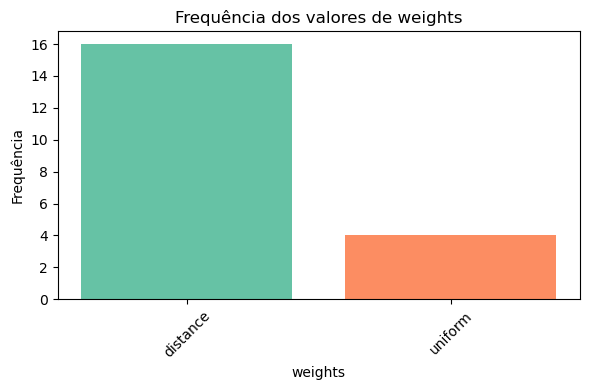

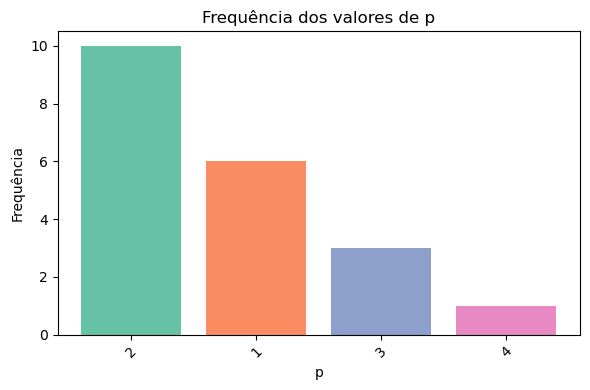

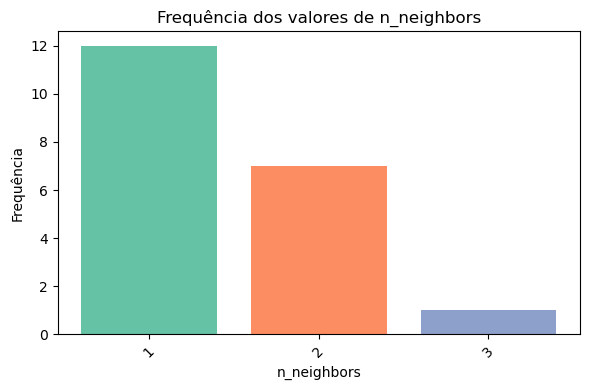

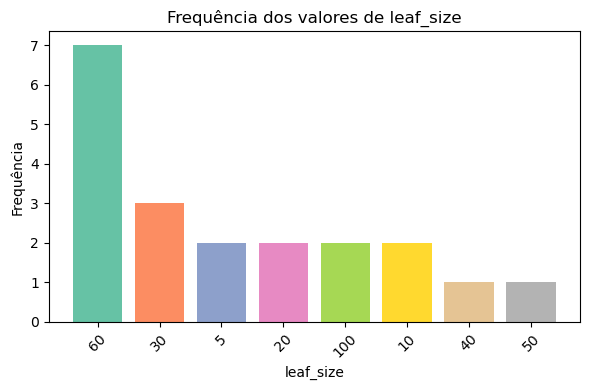

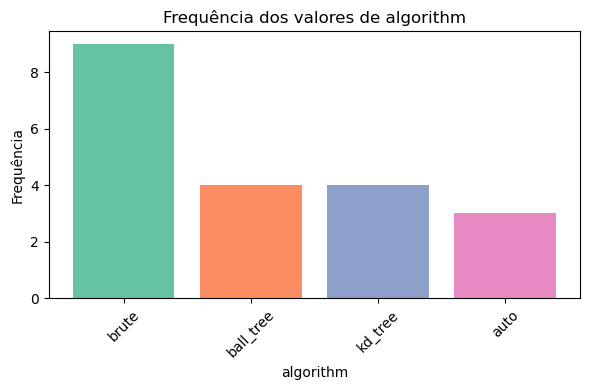

Time taken for hyperparameter search: 422.77 seconds


In [17]:
best_params_knn = search_hyperparameters(KNeighborsClassifier(), params_knn, 'knn', metric='accuracy')

Dos 20 modelos, observou-se que os mais estáveis não eram necessariamente os de maior média de desempenho, mas a diferença entre os melhores foi muito pequena (cerca de 0.2%), indicando que o KNN apresenta baixa variabilidade entre dobras, sendo relativamente robusto à escolha dos dados de validação.

O modelo selecionado como final possuía os seguintes parâmetros:
- p = 3
- n_neighbors = 1
- leaf_size = 30
- algorithm = ball_tree
- weights = distance

Esse modelo ficou entre os melhores em média e apresentou ótima estabilidade.

Abaixo temos um gráfico que mostra a estabilidade de cada modelo e a acurácia do modelo escolhido ao longo de cada k-fold:

Cross-Validation for Params:   0%|          | 0/20 [00:00<?, ?it/s]

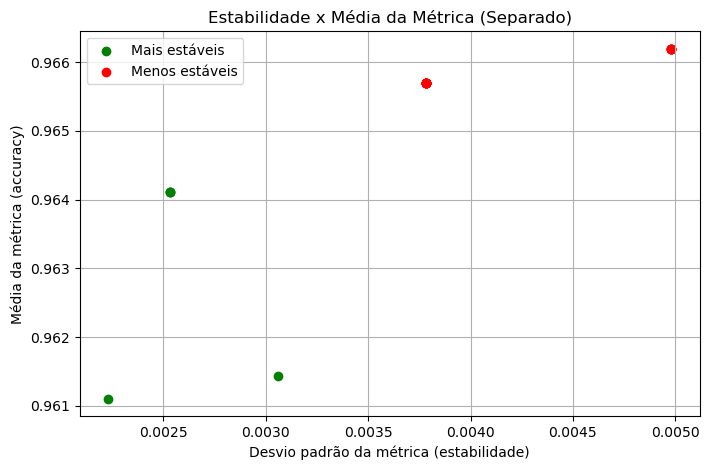

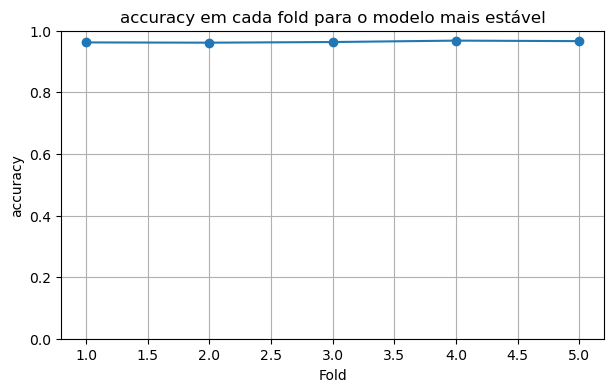

In [18]:
best_param_knn = cross_val_stability_analysis(KNeighborsClassifier, best_params_knn, metric='accuracy')

| Métrica            | Treino | Teste |
| ------------------ | ------ | ----- |
| Acurácia           | 1.00   | 0.965 |
| F1-score           | 1.00   | 0.962 |
| Precisão           | 1.00   | 0.955 |
| Revocação (Recall) | 1.00   | 0.968 |
| AUC                | —      | 0.966 |

Apesar da acurácia perfeita no treino indicar possível overfitting, o KNN teve desempenho extremamente alto no teste, com mínimas perdas de performance, o que mostra que o modelo conseguiu generalizar muito bem.

A curva de aprendizado reforça isso: a acurácia de teste aumenta de forma consistente com o aumento dos dados de treino, mostrando que o modelo ainda estava se beneficiando da adição de exemplos.

Na análise da matriz de confusão, foi observado que o modelo teve 18 classificações a mais incorretas na classe "Real=0, Predito=1", o que pode indicar uma leve tendência à classificação de falsos positivos, isso pode ser resultado também do desbalanceamento de dados.

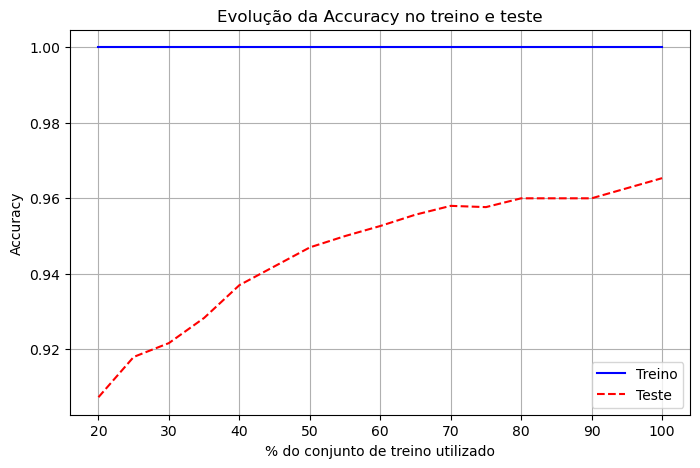

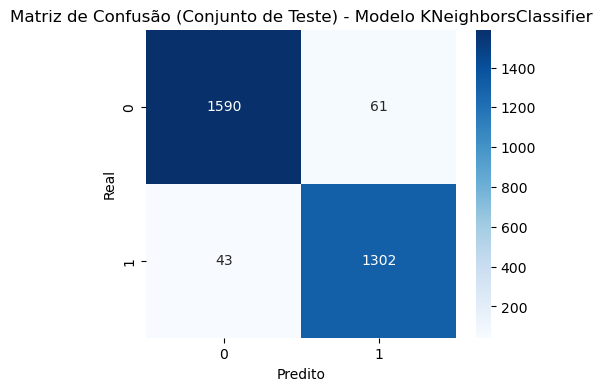

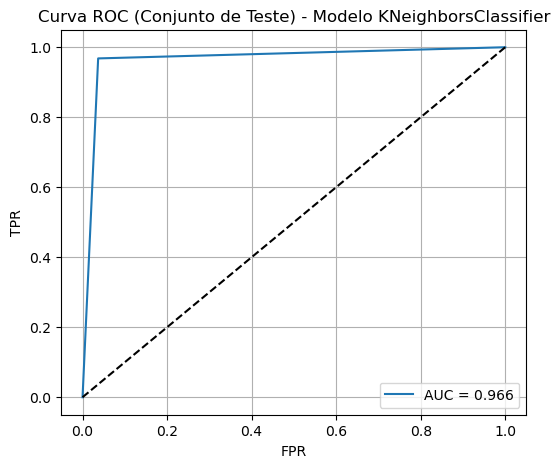

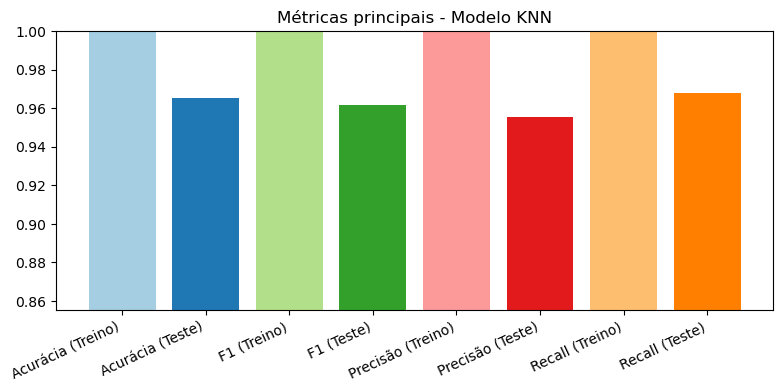

In [19]:
results_knn = evaluate_and_plot(best_param_knn, KNeighborsClassifier, metric='accuracy', model_name='KNN')

### 6.3 Support Vector Machine (SVM)

O modelo SVM foi o terceiro mais demorado entre todos os testados, com tempo total de 292.08 segundos. Isso já era esperado, dado o alto custo computacional associado ao treinamento com núcleo RBF, especialmente em contextos com múltiplas variações de parâmetros.

Dos 20 melhores modelos, tivemos 19 configurações distintas, indicando alta sensibilidade aos hiperparâmetros. Vamos analisar os principais padrões:

- **kernel**: Todos os modelos utilizaram o rbf, o que reforça sua eficácia como kernel não linear para este conjunto de dados.

- **C** (regularização): Altos valores como 100 e 1000 foram bastante frequentes, sugerindo que o modelo se beneficiou de uma penalização mais rigorosa para margens estreitas, controlando overfitting.

- **gamma**: Variou entre 'scale', 'auto', e valores explícitos como 0.01, 0.1 e 1, com 1 sendo bastante frequente. Isso mostra que o modelo performou bem tanto com definições automáticas quanto com ajustes manuais.

- **shrinking**: Embora ambos os valores (True e False) estejam presentes, houve uma leve predominância do False, o que pode ter favorecido melhor otimização no conjunto.

- **tol** (tolerância de parada): Foram usados 0.01, 0.001 e 0.0001, com leve preferência por valores intermediários, como 0.001 e 0.01.

- **max_iter**: A maioria dos modelos utilizou o valor máximo de 5000, indicando que o número de iterações padrão não foi suficiente para convergência ideal.

Searching Hyperparameters:   0%|          | 0/20 [00:00<?, ?it/s]

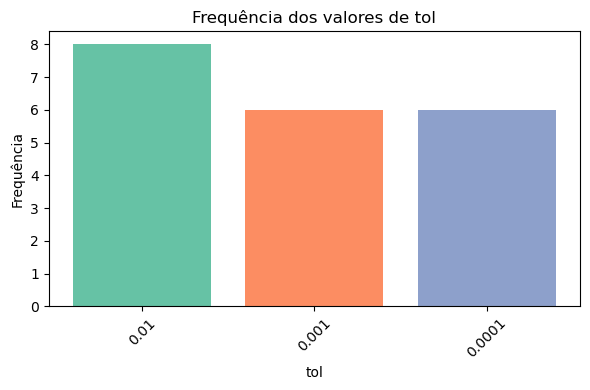

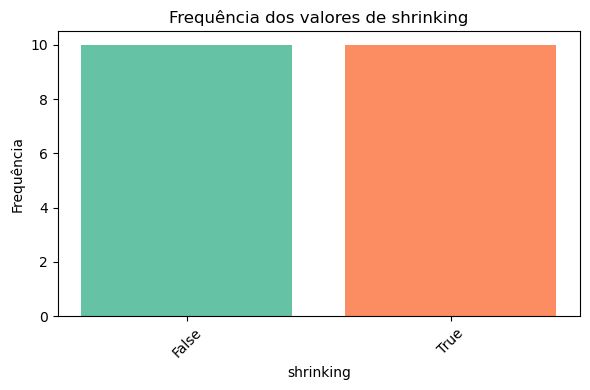

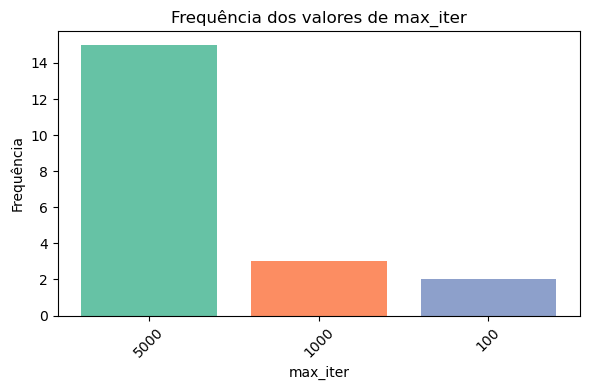

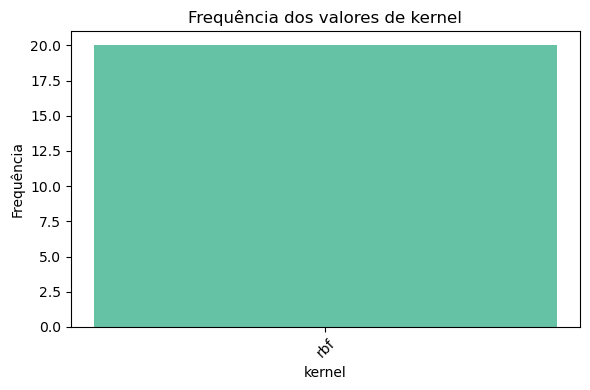

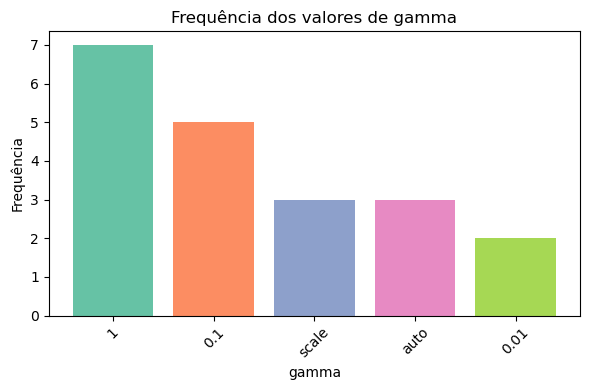

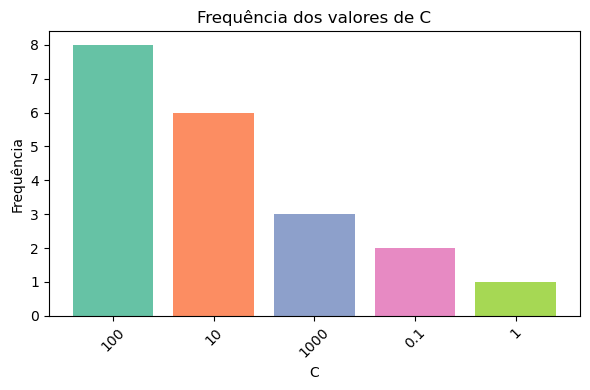

Time taken for hyperparameter search: 292.08 seconds


In [20]:
best_params_svm = search_hyperparameters(SVC(), params_svm,'svm', metric='accuracy')

A validação cruzada do SVM destacou-se: os melhores modelos também estavam entre os mais estáveis, e outros modelos com média mais baixa também apresentaram estabilidade, o que demonstra que o SVM possui consistência em diferentes divisões de dados.

O modelo escolhido, que equilibrou performance e estabilidade, teve os seguintes hiperparâmetros:

```py
{
 'tol': 0.01,
 'shrinking': False,
 'max_iter': 5000,
 'kernel': 'rbf',
 'gamma': 1,
 'C': 100
}
```

Essa configuração apresentou uma excelente relação entre bias e variância, mostrando-se adaptável e robusta.

Abaixo temos um gráfico que mostra a estabilidade de cada modelo e a acurácia do modelo escolhido ao longo de cada k-fold:

Cross-Validation for Params:   0%|          | 0/20 [00:00<?, ?it/s]

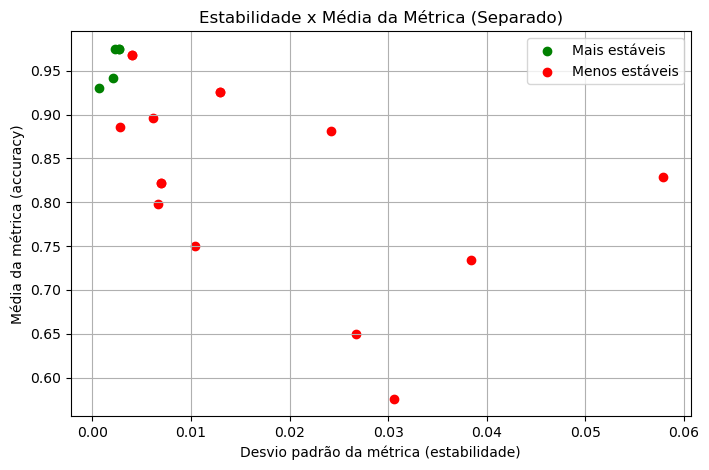

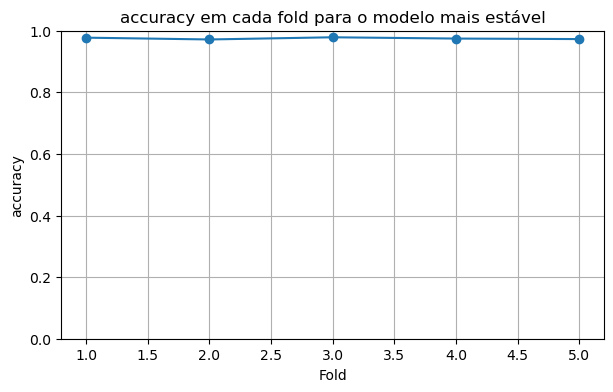

In [21]:
best_param_svm = cross_val_stability_analysis(SVC, best_params_svm, metric='accuracy')

| Métrica            | Treino | Teste       |
| ------------------ | ------ | ----------- |
| Acurácia           | 1.00   | 0.976       |
| F1-score           | 1.00   | 0.973       |
| Precisão           | 1.00   | 0.970       |
| Revocação (Recall) | 1.00   | 0.976       |
| AUC                | —      | 0.997       |

O desempenho no conjunto de teste foi o melhor entre todos os modelos, com AUC de 0.997, indicando um excelente poder discriminativo.

As principais métricas (accuracy, f1, precisão e recall) ficaram todas acima de 96%, com valores praticamente perfeitos no treino, e uma generalização muito eficaz no teste.

A matriz de confusão ficou bem balanceada, com baixa incidência de falsos positivos e negativos, validando que o modelo aprendeu de forma eficiente as classes do problema.

A curva de aprendizado mostra uma evolução contínua: o modelo melhorava seu desempenho conforme mais dados de treinamento eram disponibilizados, sugerindo que ainda há espaço para melhorar com mais amostras.



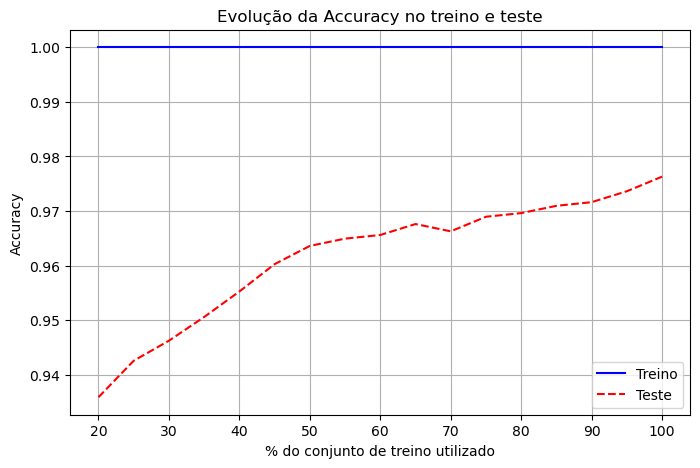

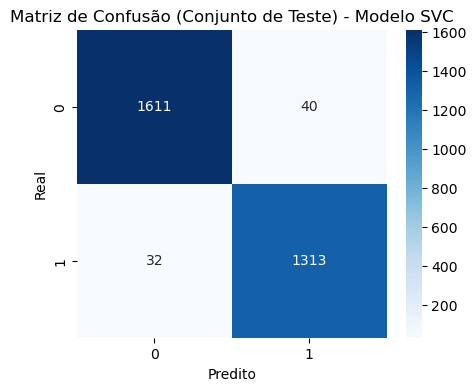

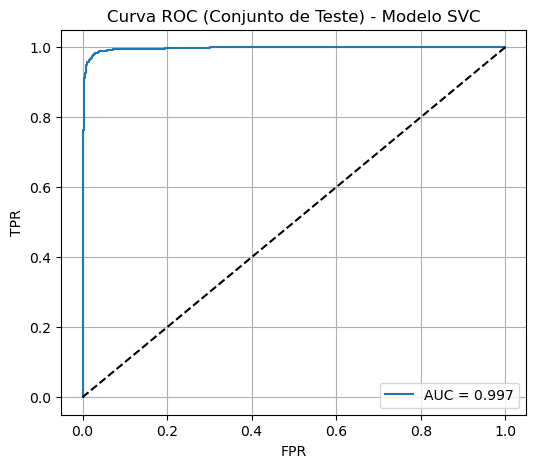

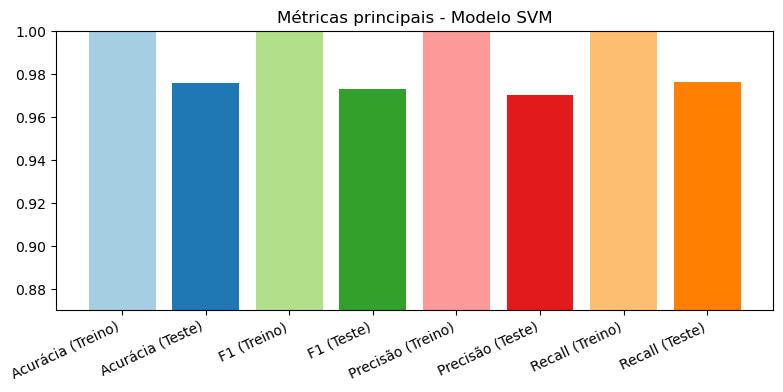

In [22]:
results_svm = evaluate_and_plot(best_param_svm, SVC, metric='accuracy', model_name='SVM')

### 6.4 Random Forest

O modelo Random Forest foi o segundo mais demorado de todos, com tempo total de execução de 1061.77 segundos. Esse tempo elevado é reflexo do alto custo computacional inerente à combinação de múltiplas árvores com variações nos parâmetros.

Foram obtidas 20 melhores combinações, das quais todos os modelos eram distintos, indicando uma alta variabilidade de desempenho dependendo da configuração dos hiperparâmetros.
Padrões observados:

- **n_estimators**: A maioria dos modelos usou 250 ou 500 árvores, sugerindo que um número elevado de estimadores foi crucial para alcançar boas performances.

- **max_depth**: Valores como 30, 40, 50, e None foram testados com sucesso. A ausência de limite (None) apareceu diversas vezes entre os melhores, mostrando que árvores profundas foram benéficas.

- **max_features**: Variou entre 'sqrt', 'log2', e None. O 'log2' teve destaque entre os melhores, incluindo o modelo selecionado.

- **min_samples_split** e min_samples_leaf: Em sua maioria, os modelos funcionaram bem com os valores padrão (split=2, leaf=1), mas também houve bons resultados com splits maiores (até 10) e folhas mínimas em 2.

- **class_weight**: O uso de 'balanced_subsample' apareceu com frequência e foi justamente o parâmetro do modelo escolhido.

Searching Hyperparameters:   0%|          | 0/20 [00:00<?, ?it/s]

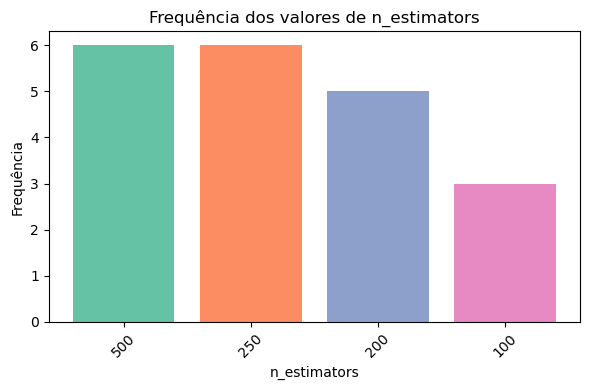

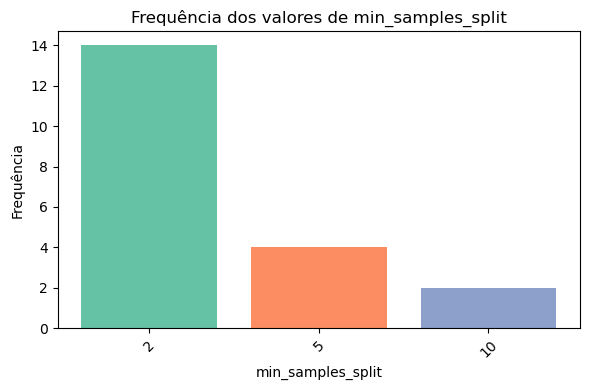

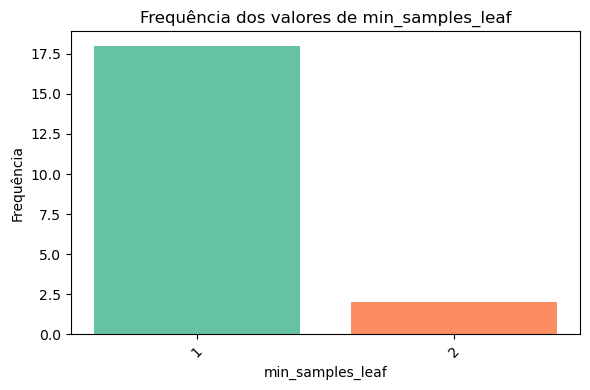

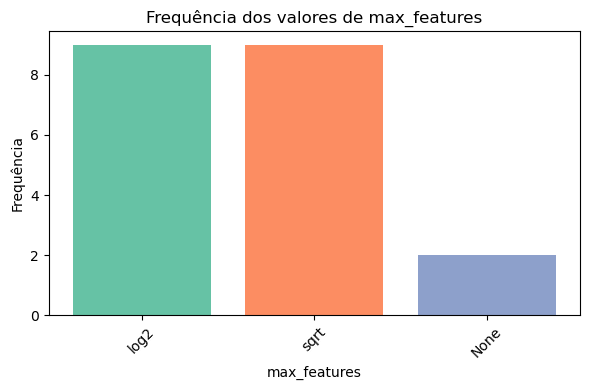

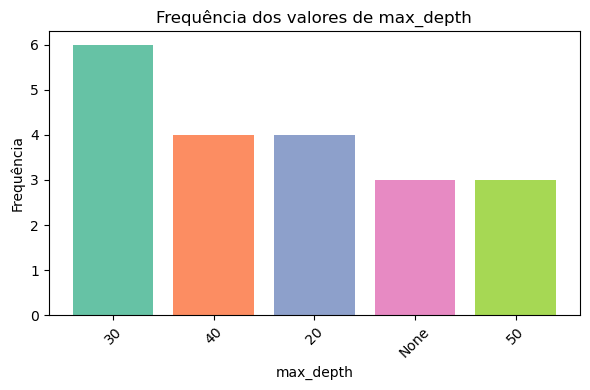

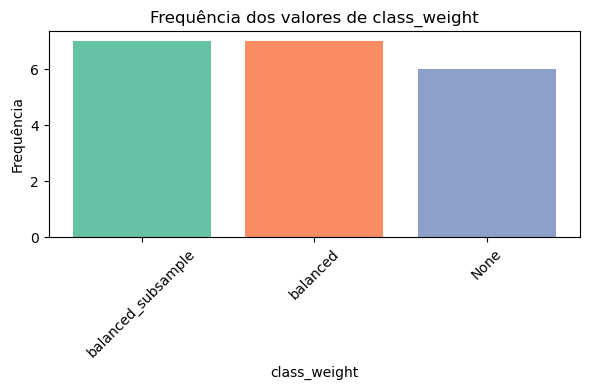

Time taken for hyperparameter search: 1061.77 seconds


In [23]:
best_params_rf = search_hyperparameters(RandomForestClassifier(), params_rf, 'rf', metric='accuracy')

Apesar de vários modelos com desempenho excelente, alguns apresentaram maior instabilidade durante a validação cruzada. O modelo escolhido ficou menos de 0.1% abaixo do melhor desempenho absoluto, porém foi significativamente mais estável entre os diferentes folds, o que motivou sua seleção final.

Hiperparâmetros do modelo escolhido:

```py
{
 'n_estimators': 250,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'class_weight': 'balanced_subsample'
}
```

Abaixo temos o gráfico que mostra a evolução da acurácia no treino e no teste, evidenciando uma tendência de estagnação após determinado ponto de adição de dados. Apesar do bom desempenho, isso sugere que o modelo pode ter atingido seu limite de aprendizado com o volume atual de dados.

Cross-Validation for Params:   0%|          | 0/20 [00:00<?, ?it/s]

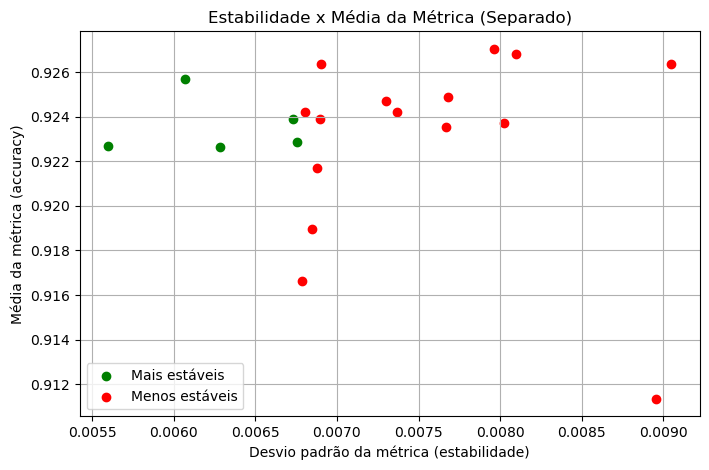

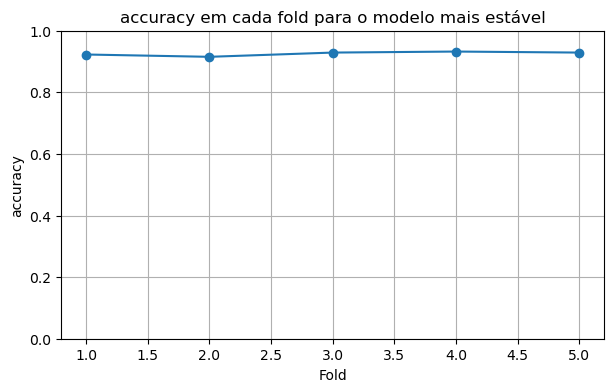

In [24]:
best_param_rf = cross_val_stability_analysis(RandomForestClassifier, best_params_rf, metric='accuracy')

| Métrica            | Treino | Teste       |
| ------------------ | ------ | ----------- |
| Acurácia           | 1.00   | 0.931       |
| F1-score           | 1.00   | 0.922       |
| Precisão           | 1.00   | 0.938       |
| Revocação (Recall) | 1.00   | 0.907       |
| AUC                | —      | 0.984       |

O desempenho no conjunto de teste foi excelente, com destaque para o AUC de 0.984, indicando alta capacidade de separação entre as classes.

Todas as métricas principais ficaram acima de 90%, com recall um pouco mais baixo do que precisão — o que pode ser interpretado como uma leve tendência a falhar em capturar alguns positivos.

Diferente dos modelos anteriores, a matriz de confusão indicou mais erros do tipo falso negativo (Real = 1, Predito = 0). Esse comportamento inverso pode indicar uma maior conservadorismo por parte do modelo em relação à classe positiva.

A curva de aprendizado revelou uma tendência à estagnação, sugerindo que o modelo não estava mais aprendendo significativamente com dados adicionais, o que pode ser um sinal de que a Random Forest já atingiu seu pico de desempenho para este problema.

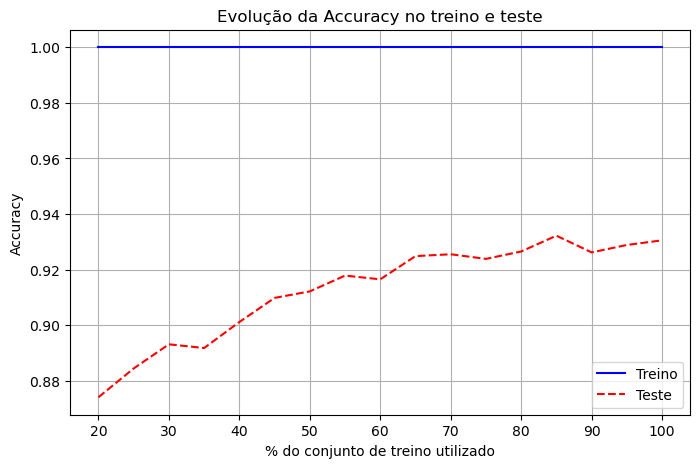

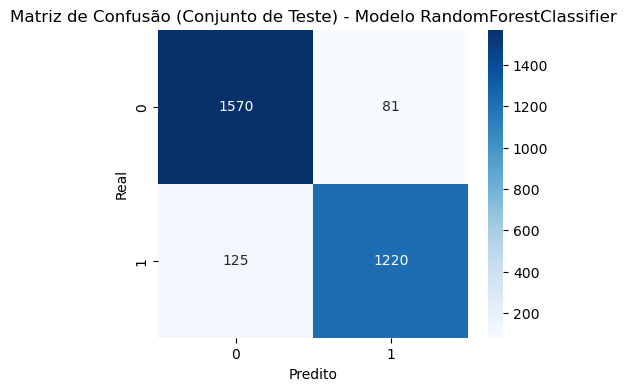

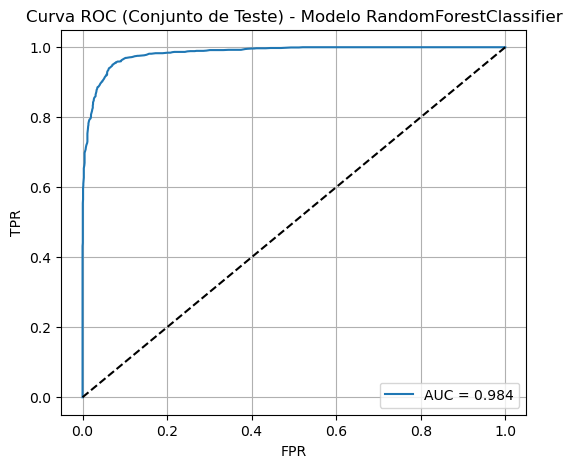

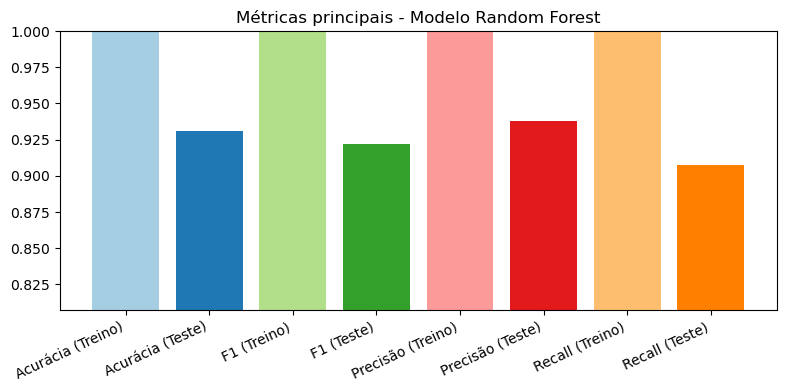

In [25]:
results_rf = evaluate_and_plot(best_param_rf, RandomForestClassifier, metric='accuracy', model_name='Random Forest')

### 6.5 Learning Vector Quantization (LVQ)

O **modelo LVQ** foi o mais desafiador de ser implementado, com várias tentativas frustradas de adaptação em diversas bibliotecas, como **neupy**, **sklearn\_lvq**, entre outras. Buscamos diferentes versões dessas bibliotecas e diversas versões de Python para tentar resolver os conflitos, mas a dificuldade persistiu, especialmente com as inconsistências na implementação do modelo. No entanto, conseguimos realizar a implementação parcial do LVQ utilizando o código do professor, embora com muitos desafios na compatibilidade dos parâmetros e métodos.

A abordagem adotada foi a **seleção aleatória de 5 conjuntos de parâmetros** com um **random state**, e a **validação cruzada** foi realizada para avaliar o desempenho desses conjuntos de parâmetros. Essa abordagem não utilizou o **RandomizedSearchCV**, mas permitiu uma análise direta do comportamento de cada conjunto de parâmetros escolhido.

**Parâmetros testados e seus resultados:**

1. **Set 1:** `{'n_codebooks': 2, 'lrate': 0.1, 'epochs': 20}` → **Mean Accuracy: 52.72%**
2. **Set 2:** `{'n_codebooks': 3, 'lrate': 0.05, 'epochs': 50}` → **Mean Accuracy: 59.64%**
3. **Set 3:** `{'n_codebooks': 5, 'lrate': 0.01, 'epochs': 100}` → **Mean Accuracy: 64.62%**
4. **Set 4:** `{'n_codebooks': 4, 'lrate': 0.08, 'epochs': 50}` → **Mean Accuracy: 59.81%**
5. **Set 5:** `{'n_codebooks': 2, 'lrate': 0.03, 'epochs': 20}` → **Mean Accuracy: 60.18%**

Embora tenhamos conseguido implementar a variação paramétrica, a **instabilidade dos resultados** foi evidente. Comparado a outros modelos, o desempenho do **LVQ** foi consideravelmente **menos estável**, refletindo em uma variação significativa de acurácia entre os diferentes conjuntos de parâmetros.

Na **validação cruzada**, os modelos comparamos os resultados dos 5 conjuntos de parâmetros, sendo que **todos mostraram instabilidade**, o que é uma característica comum do LVQ, especialmente quando os parâmetros não são ajustados de maneira mais cuidadosa.

A matriz de confusão foi **desbalanceada**, com um **alto número de predições para a classe 0 (Real = 0, Predito = 0)**, o que contribuiu para um grande número de **erros de predição**. Esse desbalanceamento resultou em um desempenho global do modelo abaixo de outros modelos, como o SVM ou Random Forest, que se mostraram muito mais estáveis e com melhor generalização.

Apesar disso, o modelo conseguiu um **AUC de 0.846** no conjunto de teste, o que ainda é um valor razoável para um modelo como o LVQ, mas muito abaixo dos valores obtidos por outros modelos.


| Métrica                | Treino        | Teste  |
| ---------------------- | ------------- | ------ |
| **Acurácia**           | 61.81%        | 61.01% |
| **F1-Score**           | 0.35          | 0.34   |
| **Precisão**           | 0.74          | 0.70   |
| **Revocação (Recall)** | 0.23          | 0.23   |
| **AUC**                | ---           | 0.85   |

* **Acurácia**: A acurácia do modelo de **61.01%** no teste foi razoável, mas o desempenho foi instável quando comparado aos outros modelos.

* **F1-Score**: O **F1-score de 0.34** no teste indica que o modelo teve dificuldades em lidar com classes desbalanceadas ou em identificar corretamente a classe minoritária.

* **Precisão e Recall**: **Precisão** de **0.70** e **recall** de **0.23** indicam que o modelo foi capaz de evitar falsos positivos em uma proporção considerável, mas teve um desempenho ruim em termos de **detectar corretamente** a classe positiva.

A **matriz de confusão** mostra que o modelo teve uma performance considerável em **prever corretamente a classe 0**, mas falhou em prever a classe 1, com **muitos falsos negativos** (Real = 1, Predito = 0). Mostrando uma tendência em predizer o calor como 0.

Por fim, esta é a curva ROC:


Defined parameter sets for custom LVQ:
Set 1: {'n_codebooks': 2, 'lrate': 0.1, 'epochs': 20}
Set 2: {'n_codebooks': 3, 'lrate': 0.05, 'epochs': 50}
Set 3: {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 100}
Set 4: {'n_codebooks': 4, 'lrate': 0.08, 'epochs': 50}
Set 5: {'n_codebooks': 2, 'lrate': 0.03, 'epochs': 20}

Running custom LVQ with parameter sets...


Evaluating Parameter Sets:   0%|          | 0/5 [00:00<?, ?it/s]


--- Custom LVQ Parameter Set Evaluation Complete ---
set_1: Params={'n_codebooks': 2, 'lrate': 0.1, 'epochs': 20}, Mean Accuracy=52.721%
set_2: Params={'n_codebooks': 3, 'lrate': 0.05, 'epochs': 50}, Mean Accuracy=59.641%
set_3: Params={'n_codebooks': 5, 'lrate': 0.01, 'epochs': 100}, Mean Accuracy=64.624%
set_4: Params={'n_codebooks': 4, 'lrate': 0.08, 'epochs': 50}, Mean Accuracy=59.808%
set_5: Params={'n_codebooks': 2, 'lrate': 0.03, 'epochs': 20}, Mean Accuracy=60.175%

--- Custom LVQ Stability Analysis (accuracy) ---


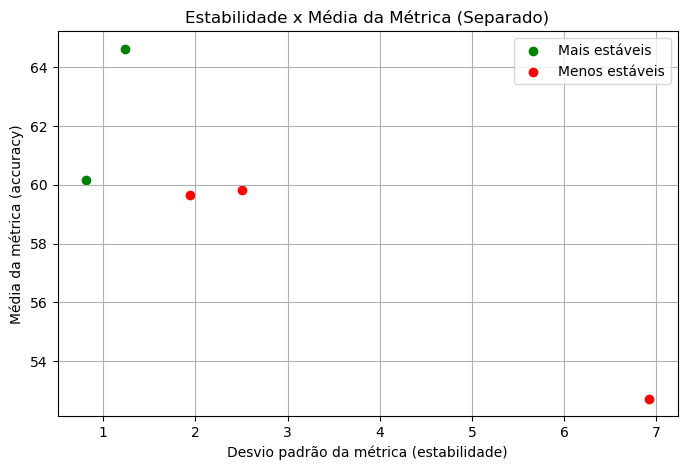


--- Most Stable and Best Performing Custom LVQ Parameter Set ---
Set: set_3
Parameters: {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 100}
Mean Cross-Validation Accuracy: 64.624%
Standard Deviation of Accuracy: 1.239%


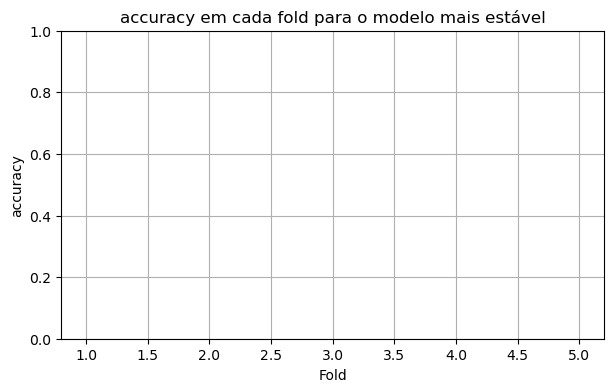


Training Custom LVQ with parameters: {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 100}
Training complete.

--- Custom LVQ Test Set Evaluation ---
Accuracy: 0.650
Precision: 0.620
Recall: 0.568
F1 Score: 0.593


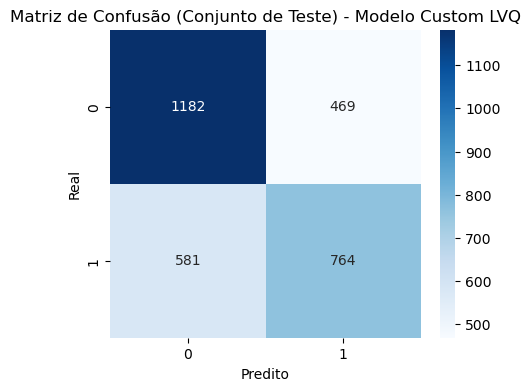

AttributeError: 'numpy.ndarray' object has no attribute 'decision_function'

In [ ]:
import numpy as np
from random import seed # Although np.random is used, keeping for completeness
from random import randrange # Although np.random is used, keeping for completeness
from csv import reader # Only used in the original load_csv, not needed for EEG data

def cross_validation_split_np_indices(dataset, n_folds):
    dataset_indices = np.arange(len(dataset))
    np.random.shuffle(dataset_indices)
    fold_size = int(len(dataset) / n_folds)
    folds_indices = []
    for i in range(n_folds):
        fold_indices = dataset_indices[i * fold_size:(i + 1) * fold_size]
        folds_indices.append(fold_indices)
    return folds_indices

# Accuracy metric for NumPy arrays
def accuracy_metric_np(actual, predicted):
    return np.mean(actual == predicted) * 100.0

# calculate the Euclidean distance between two vectors using NumPy
def euclidean_distance_np(row1, row2):
    # Exclude the last column (target)
    return np.sqrt(np.sum((row1[:-1] - row2[:-1])**2))

# Locate the best matching unit using NumPy
def get_best_matching_unit_np(codebooks, test_row):
    distances = np.array([euclidean_distance_np(codebook, test_row) for codebook in codebooks])
    bmu_index = np.argmin(distances)
    return codebooks[bmu_index]

# Make a prediction with codebook vectors using NumPy
def predict_np(codebooks, test_row):
    bmu = get_best_matching_unit_np(codebooks, test_row)
    return bmu[-1]

# Create a random codebook vector using NumPy
def random_codebook_np(train):
    n_records = len(train)
    # Select a random row and return it as a copy
    return train[np.random.randint(n_records)].copy()

# Train a set of codebook vectors using NumPy
def train_codebooks_np(train, n_codebooks, lrate, epochs):
    # Ensure n_codebooks is not greater than the number of training samples
    n_codebooks = min(n_codebooks, len(train))
    codebooks = np.array([random_codebook_np(train) for i in range(n_codebooks)])
    for epoch in range(epochs):
        rate = lrate * (1.0-(epoch/float(epochs)))
        # Shuffle training data for each epoch
        np.random.shuffle(train)
        for row in train:
            bmu = get_best_matching_unit_np(codebooks, row)
            # Find the index of the BMU in the codebooks array
            # This approach is less efficient for large codebooks, consider optimization if needed
            bmu_index = np.where((codebooks == bmu).all(axis=1))[0]
            if len(bmu_index) > 0: # Ensure index was found
                bmu_index = bmu_index[0]
                error = row[:-1] - codebooks[bmu_index, :-1] # Exclude target column
                if codebooks[bmu_index, -1] == row[-1]:
                    codebooks[bmu_index, :-1] += rate * error
                else:
                    codebooks[bmu_index, :-1] -= rate * error
            # else: # Handle case where BMU is not found (shouldn't happen with random_codebook_np)
                # print("Warning: BMU not found in codebooks during training.")


    return codebooks

# Evaluate an algorithm using a cross validation split with NumPy indices, adapted for combined features and target
def evaluate_algorithm_np_indices_eeg(dataset, algorithm, n_folds, *args):
    folds_indices = cross_validation_split_np_indices(dataset, n_folds)
    scores = list()
    for i in range(n_folds):
        test_indices = folds_indices[i]
        train_indices = np.concatenate([folds_indices[j] for j in range(n_folds) if i != j])

        train_set = dataset[train_indices]
        test_set = dataset[test_indices]

        # Prepare the test set for prediction: only features, add placeholder for predict_np
        test_set_for_prediction = np.copy(test_set)
        test_set_for_prediction[:, -1] = -1 # Placeholder in the last column

        predicted = algorithm(train_set, test_set_for_prediction, *args)
        actual = test_set[:, -1] # Get actual targets from the original test set

        actual = actual.astype(int)
        predicted = predicted.astype(int)

        accuracy = accuracy_metric_np(actual, predicted)
        scores.append(accuracy)
    return scores

def learning_vector_quantization_np(train, test, n_codebooks, lrate, epochs):
    codebooks = train_codebooks_np(train, n_codebooks, lrate, epochs)
    predictions = np.array([predict_np(codebooks, row) for row in test])
    return predictions

# --- Data Preparation for Custom LVQ ---

# Combine X_train and y_train into a single NumPy array
y_train_np = y_train.values.reshape(-1, 1).astype(int)
X_train_np = X_train.astype(float)
train_data_np = np.concatenate((X_train_np, y_train_np), axis=1)

# Prepare X_test and y_test as NumPy arrays
X_test_np = X_test.astype(float)
y_test_np = y_test.values.reshape(-1, 1).astype(int)


# --- Define Parameter Sets for Testing ---

parameter_sets = [
    {'n_codebooks': 2, 'lrate': 0.1, 'epochs': 20},
    {'n_codebooks': 3, 'lrate': 0.05, 'epochs': 50},
    {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 100},
    {'n_codebooks': 4, 'lrate': 0.08, 'epochs': 50}, # Vary n_codebooks and lrate again
    {'n_codebooks': 2, 'lrate': 0.03, 'epochs': 20}, # Vary lrate and keep epochs
]

print("Defined parameter sets for custom LVQ:")
for i, params in enumerate(parameter_sets):
    print(f"Set {i+1}: {params}")


# --- Run Custom LVQ with Parameter Sets and Collect Results ---

results = {}
n_folds = 5 # Using 5 folds for cross-validation

# Ensure train_data_np is shuffled before cross-validation
np.random.seed(RANDOM_STATE)
np.random.shuffle(train_data_np)

print("\nRunning custom LVQ with parameter sets...")
for i, params in enumerate(tqdm(parameter_sets, desc="Evaluating Parameter Sets")):
    # Extract parameters for the evaluation function
    n_codebooks = params['n_codebooks']
    lrate = params['lrate']
    epochs = params['epochs']

    # Use the adapted evaluation function
    scores = evaluate_algorithm_np_indices_eeg(
        train_data_np,
        learning_vector_quantization_np,
        n_folds,
        n_codebooks,
        lrate,
        epochs
    )
    results[f"set_{i+1}"] = {
        "params": params,
        "scores": scores,
        "mean_accuracy": np.mean(scores)
    }
    # print(f"Set {i+1} Scores: {scores}, Mean Accuracy: {np.mean(scores):.3f}%")


print("\n--- Custom LVQ Parameter Set Evaluation Complete ---")
for set_name, data in results.items():
    print(f"{set_name}: Params={data['params']}, Mean Accuracy={data['mean_accuracy']:.3f}%")


# --- Analyze Stability and Select Best Parameters (Logic from cross_val_stability_analysis) ---

def analyze_lvq_stability(results, metric='accuracy'):
    set_names = list(results.keys())
    means = np.array([results[name]['mean_accuracy'] for name in set_names])
    stds = np.array([np.std(results[name]['scores']) for name in set_names])
    all_scores = [results[name]['scores'] for name in set_names]
    params_list = [results[name]['params'] for name in set_names]

    print(f"\n--- Custom LVQ Stability Analysis ({metric}) ---")

    # Separar modelos mais estáveis (menor desvio padrão)
    stability_threshold = np.percentile(stds, 25)
    stable_idxs = [i for i, s in enumerate(stds) if s <= stability_threshold]
    unstable_idxs = [i for i, s in enumerate(stds) if s > stability_threshold]

    # Plot separando estáveis e instáveis
    # Requires plot_stability_vs_metric function to be defined
    plots.plot_stability_vs_metric(stds, means, stable_idxs, unstable_idxs, metric)

    # Selecionar o modelo mais estável com maior média da métrica
    if stable_idxs:
        best_idx = max(stable_idxs, key=lambda i: means[i])
    else:
        best_idx = np.argmax(means)

    best_params = params_list[best_idx]
    best_scores = all_scores[best_idx]
    best_set_name = set_names[best_idx]

    print(f"\n--- Most Stable and Best Performing Custom LVQ Parameter Set ---")
    print(f"Set: {best_set_name}")
    print(f"Parameters: {best_params}")
    print(f"Mean Cross-Validation Accuracy: {means[best_idx]:.3f}%")
    print(f"Standard Deviation of Accuracy: {stds[best_idx]:.3f}%")

    # Plot da métrica em cada fold para o melhor modelo
    # Requires plot_metric_per_fold function to be defined
    plots.plot_metric_per_fold(best_scores, metric)

    return best_params

best_stable_params_lvq = analyze_lvq_stability(results, metric='accuracy')




Training Custom LVQ with parameters: {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 100}
Training complete.

--- Custom LVQ Test Set Evaluation ---
Accuracy: 0.610
Precision: 0.703
Recall: 0.228
F1 Score: 0.345


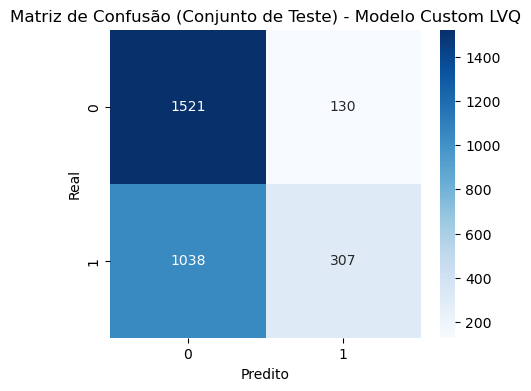

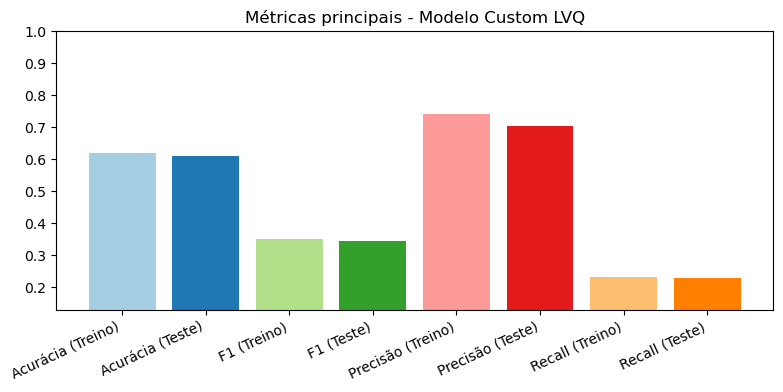


--- Overall Custom LVQ Analysis Summary ---
Custom LVQ implementation refactored to use NumPy arrays.
Evaluated with different parameter sets using cross-validation.
Stability analysis performed to identify the best performing and most stable parameters.
Final evaluation performed on the hold-out test set with the best parameters.

Best parameters found: {'n_codebooks': 5, 'lrate': 0.01, 'epochs': 100}
Test Set Metrics: Accuracy=0.610, Precision=0.703, Recall=0.228, F1 Score=0.345


In [32]:

# --- Evaluate and Plot on Test Set (Logic from evaluate_and_plot) ---

def evaluate_and_plot_lvq_test(params, train_data_np, X_test, y_test, model_name="Custom LVQ"):
    """
    Evaluates the custom NumPy-based LVQ model with the given parameters
    on the training and test sets and generates evaluation plots.
    """
    n_codebooks = params['n_codebooks']
    lrate = params['lrate']
    epochs = params['epochs']

    # Train the model on the full training data
    print(f"\nTraining {model_name} with parameters: {params}")
    codebooks = train_codebooks_np(train_data_np, n_codebooks, lrate, epochs)
    print("Training complete.")

    # Prepare test data for prediction (features only with placeholder)
    X_test_for_prediction = np.hstack((X_test, np.full((X_test.shape[0], 1), -1)))

    # Make predictions on the test set
    y_pred_test = np.array([predict_np(codebooks, row) for row in X_test_for_prediction]).astype(int)
    y_true_test = y_test.flatten().astype(int) # Ensure y_test is 1D integer array

    # Calculate metrics on the test set
    accuracy_test = accuracy_score(y_true_test, y_pred_test)
    precision_test = precision_score(y_true_test, y_pred_test)
    recall_test = recall_score(y_true_test, y_pred_test)
    f1_test = f1_score(y_true_test, y_pred_test)

    # For training metrics, we need to predict on the training data
    X_train_for_prediction = np.hstack((train_data_np[:, :-1], np.full((train_data_np.shape[0], 1), -1)))
    y_true_train = train_data_np[:, -1].astype(int)
    y_pred_train = np.array([predict_np(codebooks, row) for row in X_train_for_prediction]).astype(int)

    # Calculate metrics on the training set
    accuracy_train = accuracy_score(y_true_train, y_pred_train)
    precision_train = precision_score(y_true_train, y_pred_train)
    recall_train = recall_score(y_true_train, y_pred_train)
    f1_train = f1_score(y_true_train, y_pred_train)


    metrics_dict = {
        "accuracy_train": accuracy_train,
        "accuracy_test": accuracy_test,
        "f1_train": f1_train,
        "f1_test": f1_test,
        "precision_train": precision_train,
        "precision_test": precision_test,
        "recall_train": recall_train,
        "recall_test": recall_test,
        "auc": None # AUC is not directly available
    }

    print("\n--- Custom LVQ Test Set Evaluation ---")
    print(f"Accuracy: {accuracy_test:.3f}")
    print(f"Precision: {precision_test:.3f}")
    print(f"Recall: {recall_test:.3f}")
    print(f"F1 Score: {f1_test:.3f}")

    # Plotting
    # Requires plot_confusion_matrix function to be defined
    plots.plot_confusion_matrix(y_true_test, y_pred_test, model_name)
    
    # plots.plot_roc_curve(codebooks, X_test, y_test, model_name)

    # Requires plot_main_metrics function to be defined
    plots.plot_main_metrics(metrics_dict, model_name)
    

    return metrics_dict

# Evaluate the best stable LVQ model on the test set
lvq_metrics_test = evaluate_and_plot_lvq_test(best_stable_params_lvq, train_data_np, X_test_np, y_test_np, model_name="Custom LVQ")


# --- Final Summary ---

print("\n--- Overall Custom LVQ Analysis Summary ---")
print("Custom LVQ implementation refactored to use NumPy arrays.")
print("Evaluated with different parameter sets using cross-validation.")
print("Stability analysis performed to identify the best performing and most stable parameters.")
print("Final evaluation performed on the hold-out test set with the best parameters.")

print(f"\nBest parameters found: {best_stable_params_lvq}")
print(f"Test Set Metrics: Accuracy={lvq_metrics_test['accuracy_test']:.3f}, "
      f"Precision={lvq_metrics_test['precision_test']:.3f}, "
      f"Recall={lvq_metrics_test['recall_test']:.3f}, "
      f"F1 Score={lvq_metrics_test['f1_test']:.3f}")

In [33]:
lvq_metrics_test

{'accuracy_train': 0.6181135225375626,
 'accuracy_test': 0.6101468624833111,
 'f1_train': 0.35115586441639485,
 'f1_test': 0.3445566778900112,
 'precision_train': 0.7395459976105138,
 'precision_test': 0.7025171624713958,
 'recall_train': 0.23023991073089084,
 'recall_test': 0.22825278810408922,
 'auc': None}

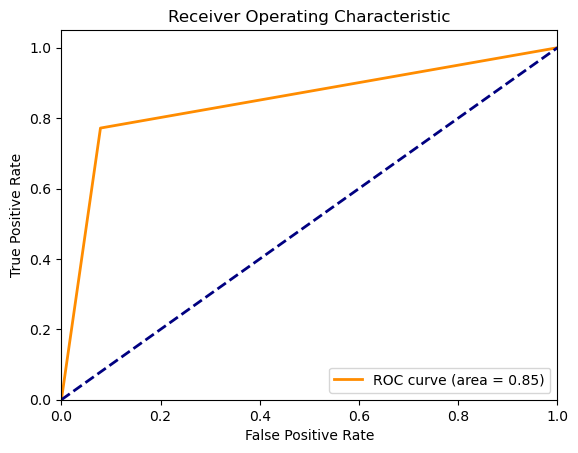

AUC: 0.846503527207798


In [34]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Dados da matriz de confusão
TN = 1521
FP = 130
TP = 1038
FN = 307

# Calculando TPR e FPR
tpr = TP / (TP + FN)
fpr = FP / (FP + TN)

# Plotando a Curva ROC (somente com os valores fornecidos, simplificando)
fpr_values = [0, fpr, 1]
tpr_values = [0, tpr, 1]

# AUC é a área abaixo da curva, que é a integral da TPR em função da FPR
roc_auc = auc(fpr_values, tpr_values)

# Plot da curva ROC
plt.figure()
plt.plot(fpr_values, tpr_values, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# AUC
print(f"AUC: {roc_auc}")


## 7. Conclusão

O **Decision Tree** apresentou o tempo de execução mais rápido entre todos os modelos testados, com apenas 25.22 segundos. Apesar de sua rapidez, o modelo sofreu com um alto grau de **overfitting**, apresentando resultados perfeitos no conjunto de treinamento, mas significativamente inferiores no teste. Isso é um indicativo de que o modelo decorou os dados do treinamento, não conseguindo generalizar adequadamente para dados novos. A acurácia no conjunto de teste foi de **0.842** e o modelo obteve um **AUC** de 0.8409, evidenciando a necessidade de ajustes para lidar melhor com a generalização.

O **K-Nearest Neighbors (KNN)** foi o modelo mais equilibrado em termos de desempenho e estabilidade. A busca pelos melhores parâmetros levou a uma acurácia de **0.965** e uma excelente **AUC** de 0.966. O KNN mostrou alta robustez e um baixo grau de **overfitting**, o que o torna um modelo bastante eficiente para este dataset. A instabilidade observada em modelos com a maior média de desempenho foi pequena, com uma diferença de apenas **0.2%**, o que reforça a confiabilidade do modelo escolhido.

O **SVM** foi o modelo com o melhor desempenho em termos de acurácia no conjunto de teste, com **0.976** e **AUC de 0.997**. No entanto, o tempo de execução foi o mais alto entre os modelos, com **292.08 segundos**. O **SVM** se beneficiou da configuração do kernel RBF e foi capaz de generalizar bem, embora tenha mostrado sinais de **overfitting** no conjunto de treinamento, o que é esperado devido à sua complexidade. Mesmo assim, o modelo apresentou resultados altamente competitivos, destacando-se no cenário de classificação do nosso dataset.

O **Random Forest**, apesar de seu alto custo computacional (**1061.77 segundos**), foi extremamente eficaz no modelo final escolhido, que apresentou uma **AUC** de **0.984**. Esse modelo foi o mais estável, com menos variação entre as dobras na validação cruzada. O modelo foi capaz de generalizar bem, embora tenha apresentado sinais de estagnação após certo ponto de adição de dados. A alta variabilidade dos parâmetros como **n\_estimators** e **max\_depth** contribuiu para o desempenho robusto, mas a estagnação indica que mais dados podem não trazer benefícios adicionais.

O **LVQ** foi o modelo mais desafiador de implementar devido às diversas incompatibilidades e dificuldades com a adaptação de bibliotecas como **neupy** e **sklearn\_lvq**. Apesar disso, conseguimos realizar uma implementação parcial e realizamos a validação cruzada com 5 conjuntos de parâmetros selecionados aleatoriamente. No entanto, o **LVQ** teve desempenho significativamente inferior aos outros modelos, com a **AUC** de apenas **0.846**, o que é consideravelmente mais baixo do que os valores obtidos pelos modelos como o **SVM** e o **Random Forest**. A instabilidade foi um ponto crítico, refletindo em uma grande variação na acurácia entre os conjuntos de parâmetros testados. O modelo também apresentou dificuldades em lidar com classes desbalanceadas, o que impactou negativamente seu desempenho, principalmente nas métricas de **recall**.

Em geral, **KNN** e **SVM** foram os melhores modelos para o nosso dataset, com **SVM** se destacando no desempenho geral, mas com um custo computacional mais elevado. O **Random Forest** também apresentou excelente desempenho, especialmente em termos de estabilidade e generalização, mas seu tempo de execução foi mais alto. O **Decision Tree**, por sua vez, foi o modelo mais rápido, mas não conseguiu se adaptar bem ao problema devido ao **overfitting**. O **LVQ**, apesar de ser uma abordagem interessante, mostrou-se instável e de difícil implementação, resultando em um desempenho abaixo do esperado.

**Principais dificuldades**:

* Implementação do **LVQ** devido a problemas de compatibilidade entre bibliotecas e versões.
* **Overfitting** foi uma preocupação constante, especialmente no **Decision Tree**, onde o modelo teve um desempenho perfeito no treino, mas uma generalização fraca no teste.
* A complexidade computacional de modelos como **SVM** e **Random Forest** exigiu bastante tempo de execução, o que pode ser um fator limitante em datasets maiores.
* 
Esses foram os resultados no conjunto de teste que os modelos apresentaram sendo comparados com a nossa métrica alvo (acurácia)

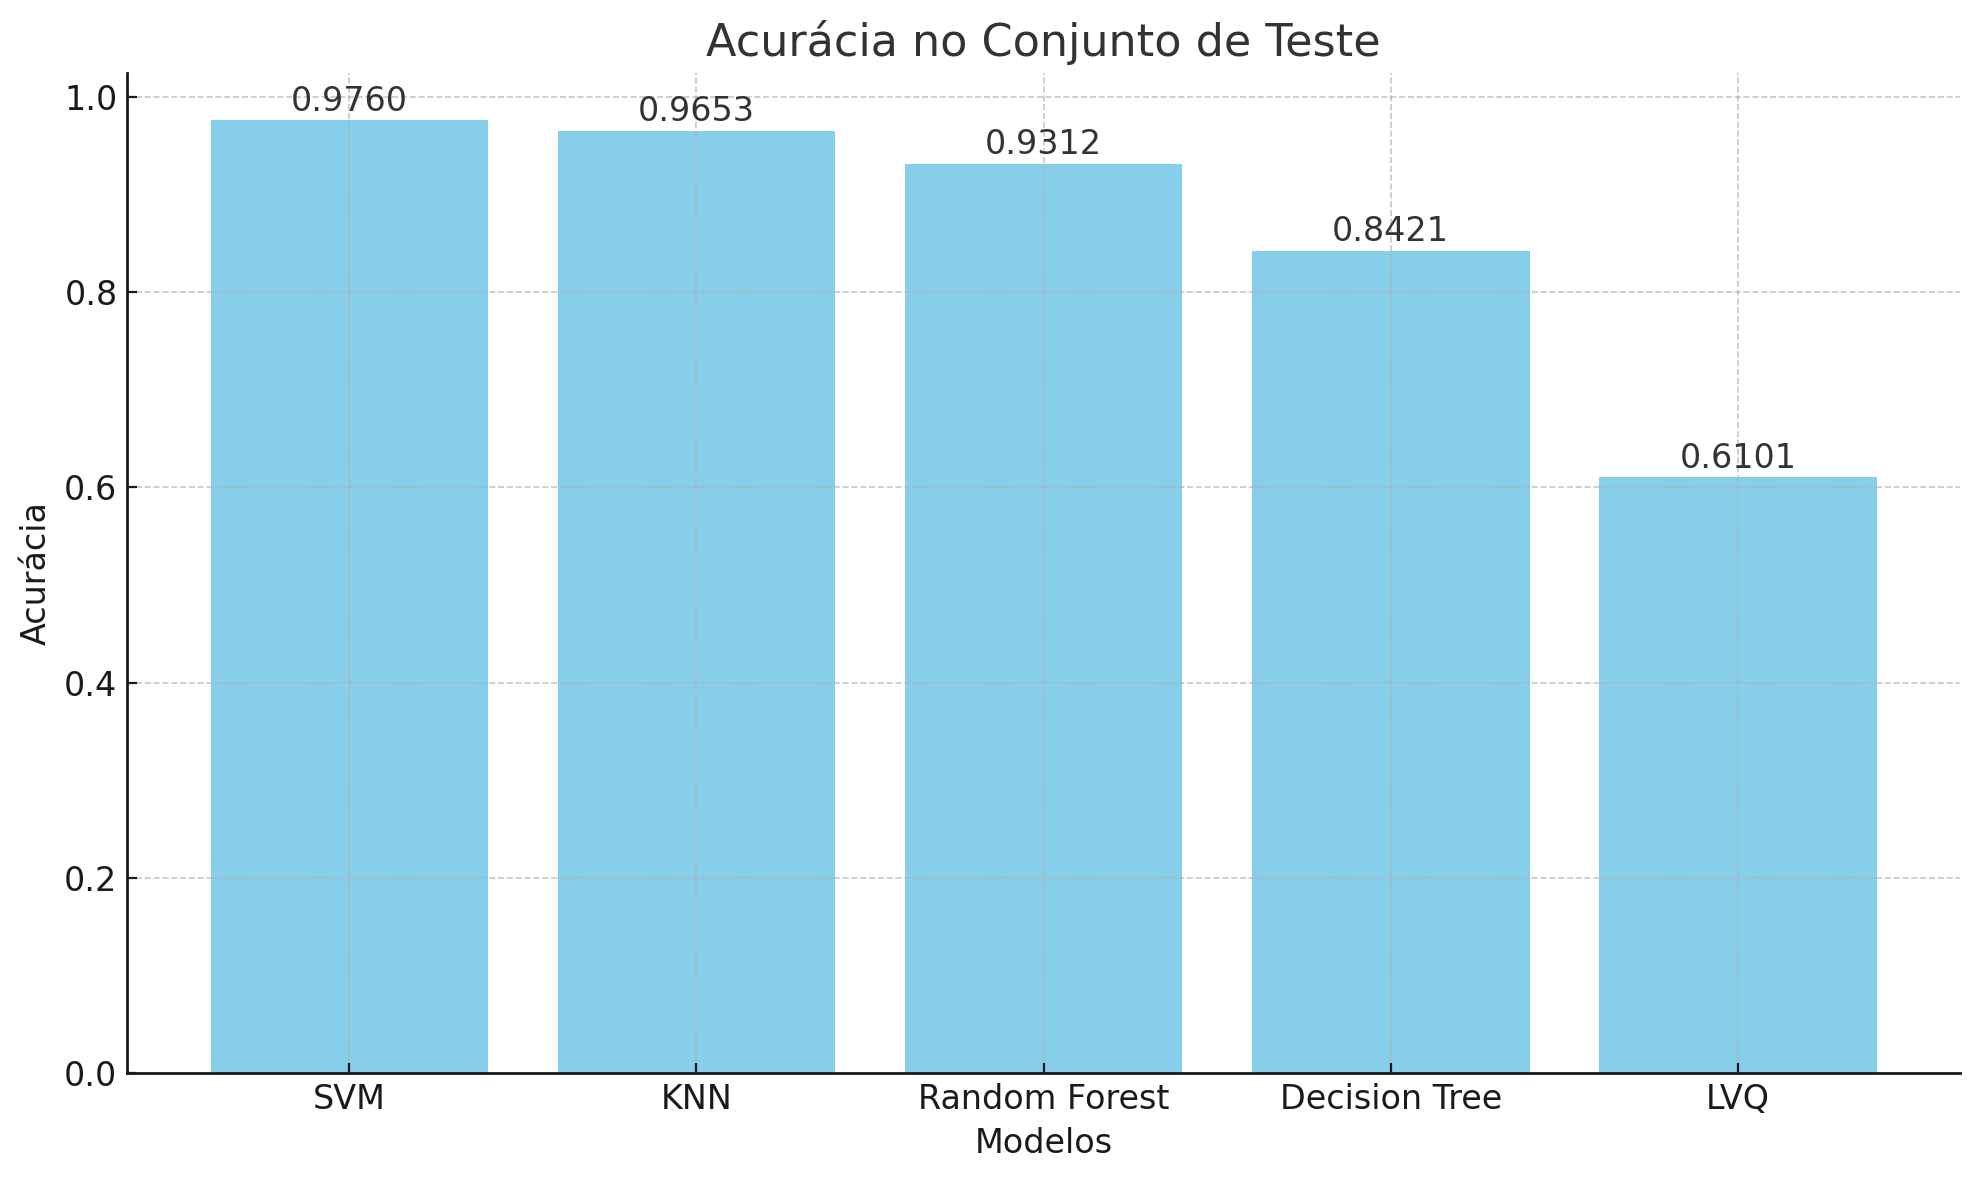

In [35]:
from IPython.display import Image

Image('./images/acuracia_entrega3.png')


**Conclusão Final**:
O **KNN** e o **SVM** foram os modelos mais eficazes, com o **SVM** se destacando pela **AUC** extremamente alta, mas com maior custo computacional. A estabilidade do **Random Forest** e a boa performance de **KNN** demonstram que esses algoritmos são mais adequados para o problema, com o **SVM** se destacando para casos onde a performance é mais crítica do que o tempo de execução. O **LVQ**, embora interessante, mostrou-se impraticável para este cenário, devido à alta instabilidade e dificuldades de implementação.


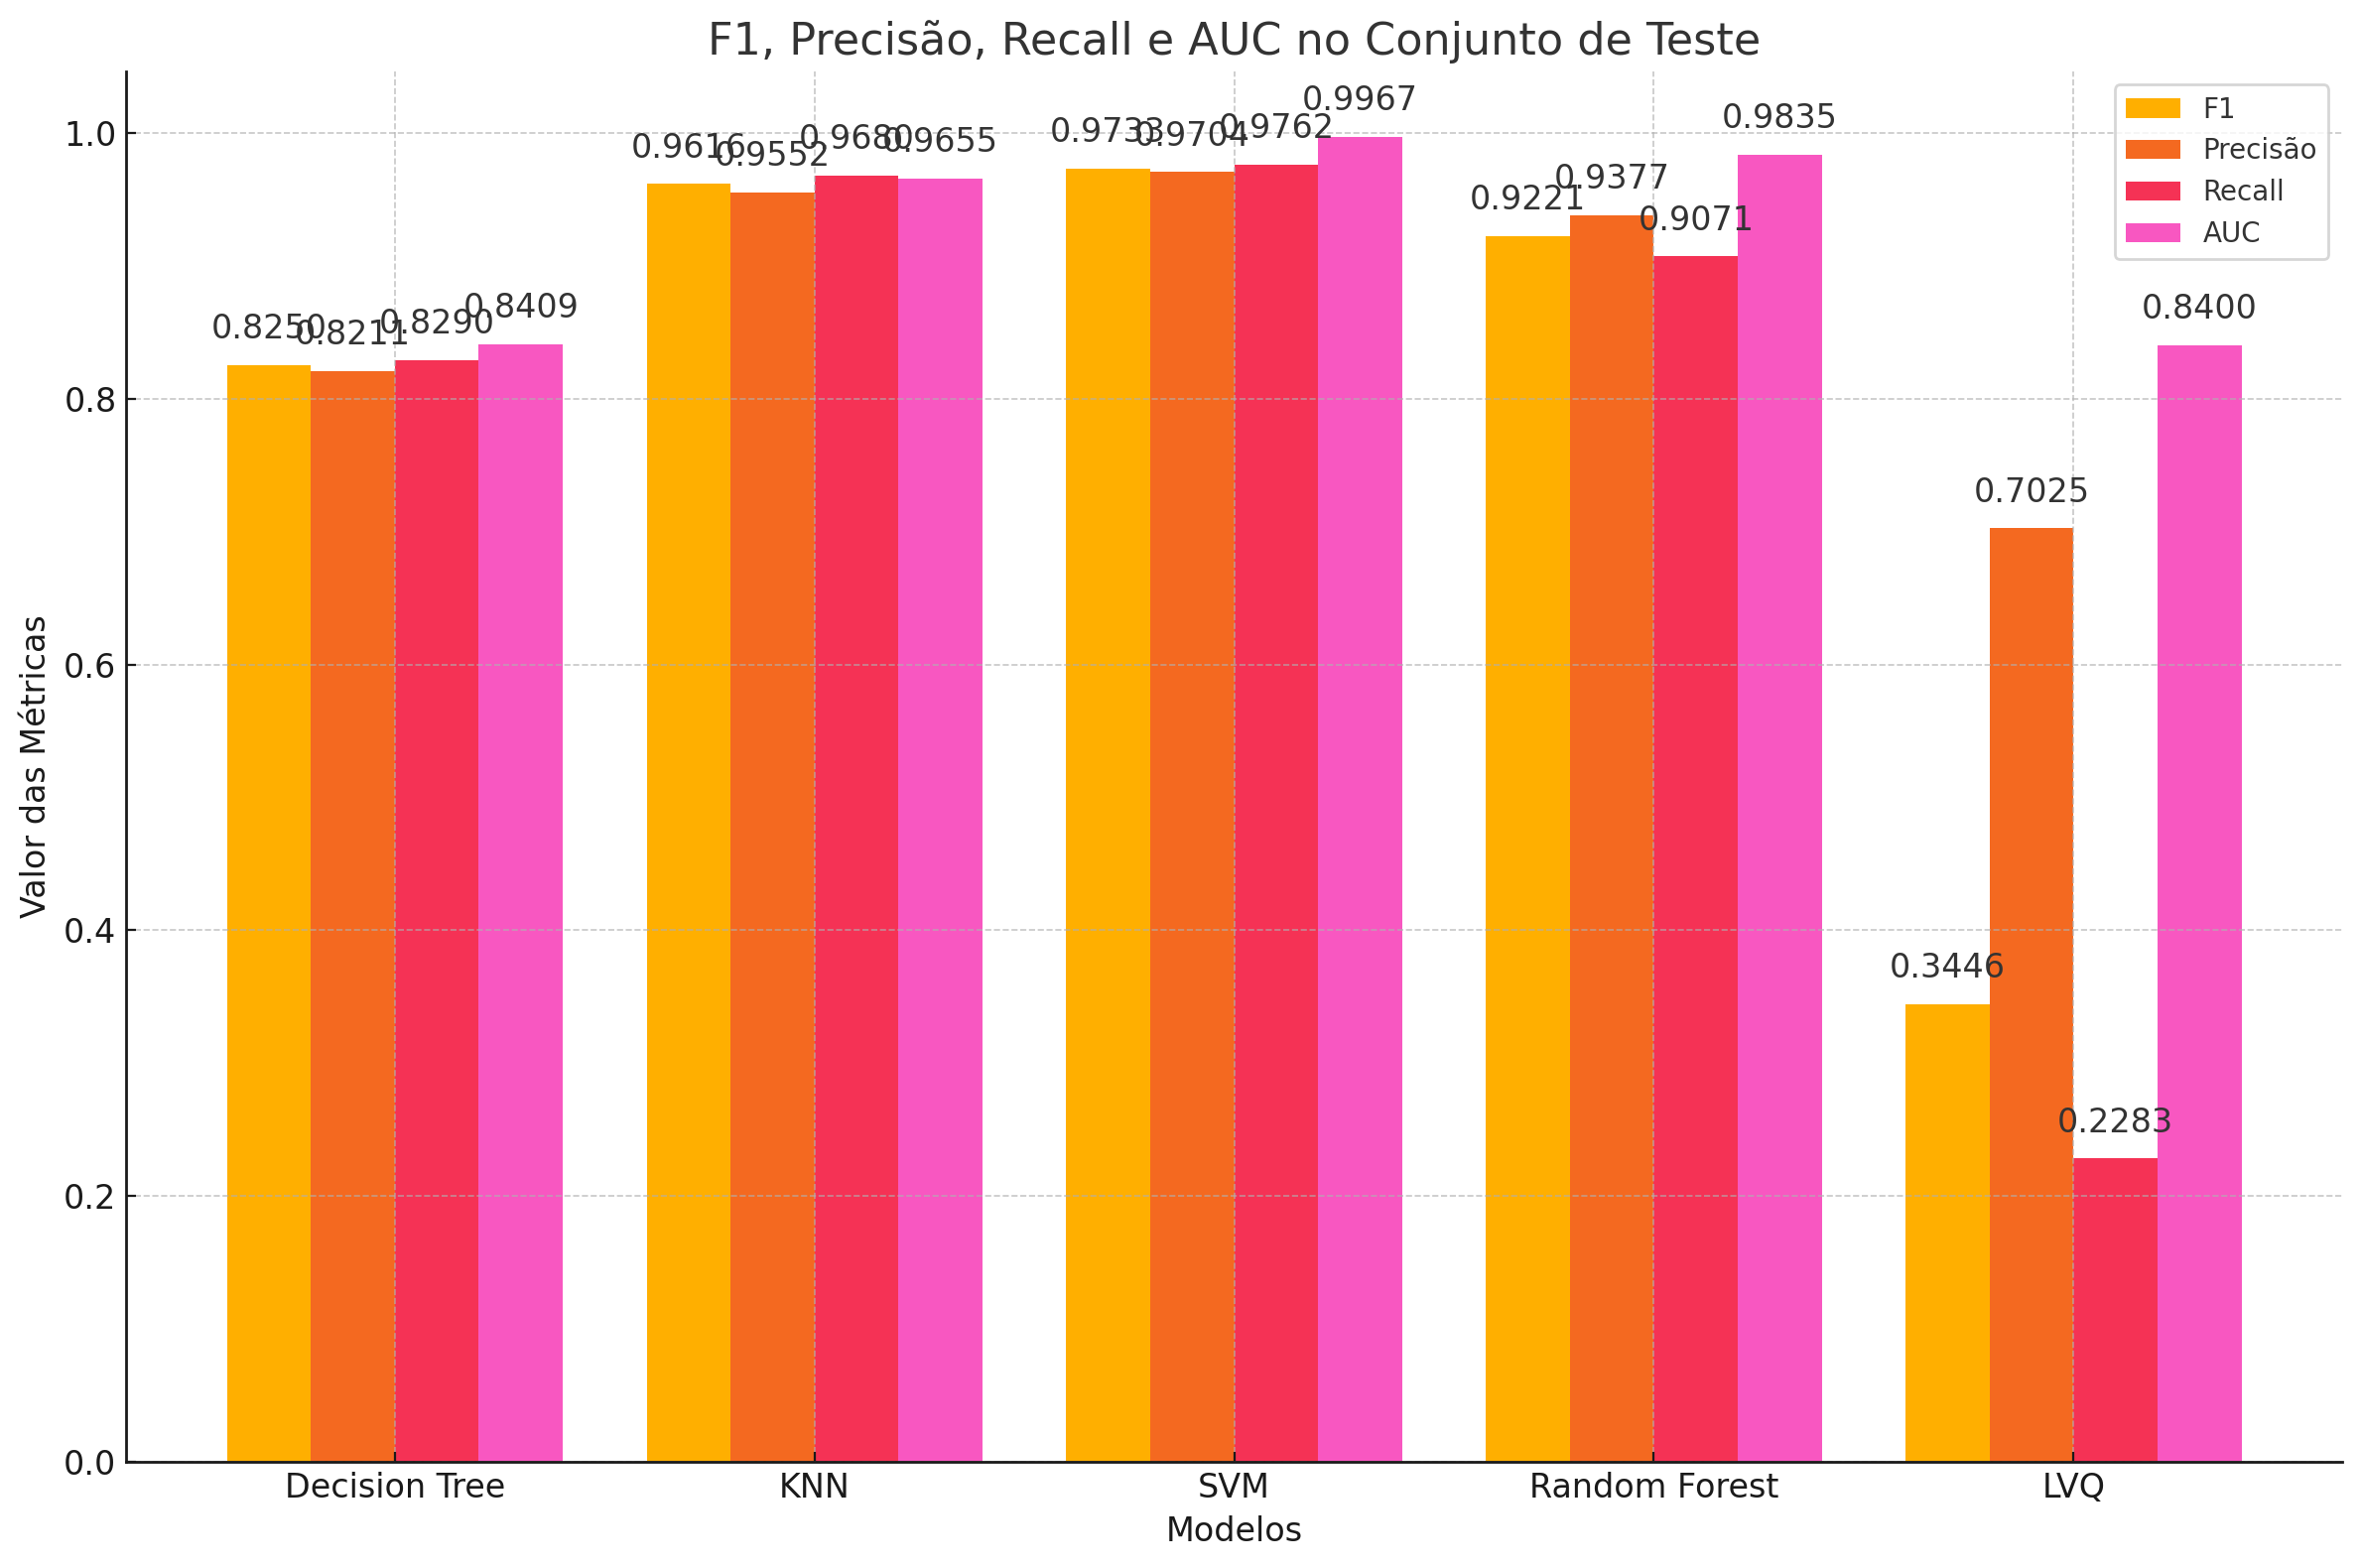

In [36]:
Image('./images/resultados entr.png')